In [4]:
library(edgeR)
library(ggplot2)
library(ggrepel)
library(reshape2)
library(scales)
library(gridExtra)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(biomaRt)
library(patchwork)
library(ComplexHeatmap)
library(circlize)
library(ggrastr)
library(dplyr)
library(patchwork)
library(ChIPseeker)

## Plot ChromVAR

In [3]:
all_chromvar = read.csv("../data/210629_thp1_chromvar.csv")
dev_human_vals_mean = (all_chromvar[,(c(1:5)*2 - 1)] + all_chromvar[,(c(1:5)*2)])/2
colnames(dev_human_vals_mean) = c("DMSO", "BRQ 24h", "BRQ 48h", "PMA 24", "PMA 48h")
head(dev_human_vals_mean)

,DMSO,BRQ 24h,BRQ 48h,PMA 24,PMA 48h
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SMARCC1,-0.1725690,-0.04034154,0.06261543,0.09523380,0.03305613
JUNB,-0.1827696,-0.04514217,0.06470005,0.10193946,0.03794427
FOSL1,-0.1783796,-0.04144049,0.06379887,0.09805670,0.03538317
FOSL2,-0.1845922,-0.04462414,0.06448878,0.10223978,0.03933368
FOS,-0.1741598,-0.03883304,0.06538234,0.09183981,0.03395977
JUND,-0.1703025,-0.03701775,0.06256689,0.09122357,0.03230963


Warning message:
“The input is a data frame, convert it to a matrix.”


pdf 
  2

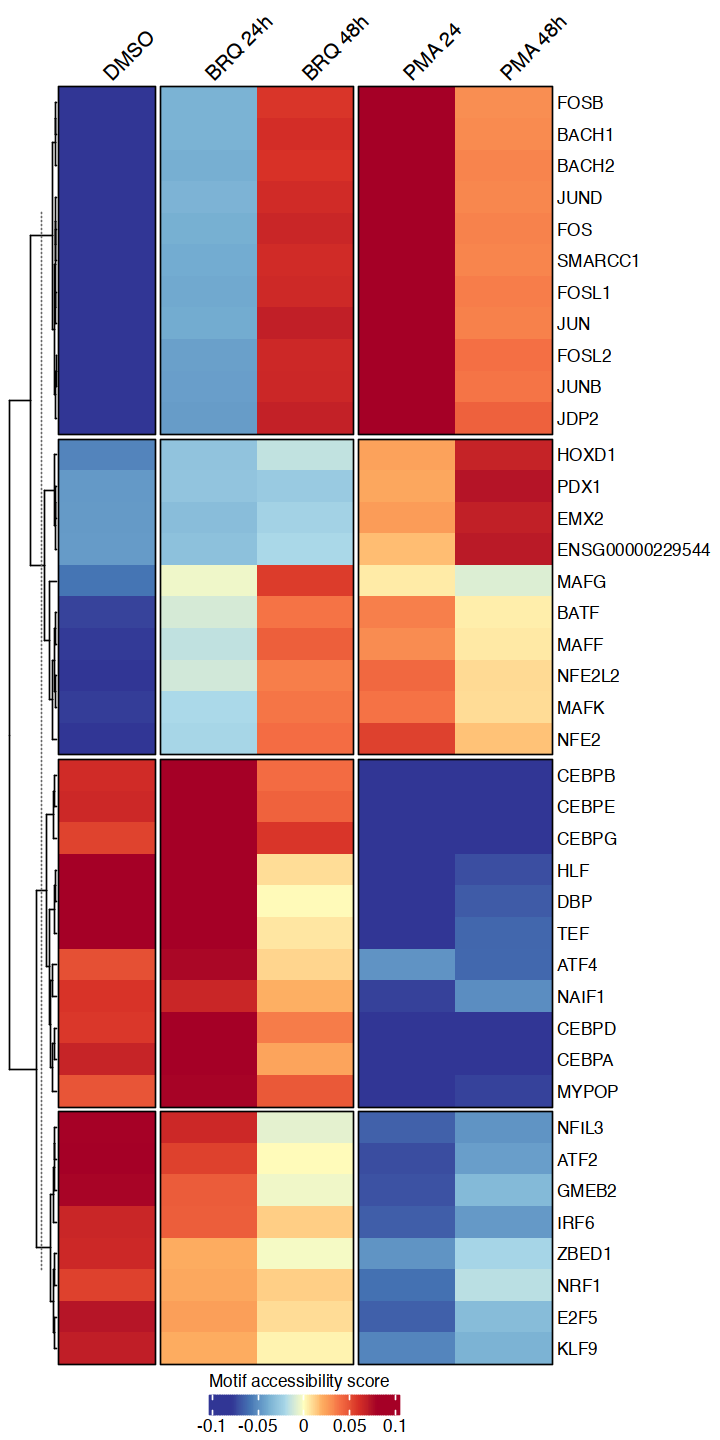

In [4]:
# Top 40 motifs

chromvar_range = apply(dev_human_vals_mean, 1, function(x) abs(range(x)[2] - range(x)[1]))
hirange = names(chromvar_range[order(-chromvar_range)][1:40])

options(repr.plot.width=6, repr.plot.height=12)
h = Heatmap(dev_human_vals_mean[hirange,], 
        cluster_columns = F, 
        cluster_rows = T,
        row_km=5,
        row_km_repeats=100,
        column_names_side = "top", 
        column_names_rot = 45,
        column_split=c(1,2,2,3,3),
        column_title=NULL,
        row_title=NULL,
        border=T,
        row_title_rot=0,
        row_names_gp = gpar(fontsize = 10),
        col = colorRamp2(seq(-0.08, 0.08, length.out = 9), 
                         rev(RColorBrewer::brewer.pal(name = "RdYlBu", n = 11))[c(1:4, 6, 8:11)]),
       heatmap_legend_param = list(
                title="Motif accessibility score",
                direction="horizontal"))

draw(h, heatmap_legend_side="bottom")

pdf("../output/220510_thp1_top30_atac.pdf", width=4, height=6)
draw(h, heatmap_legend_side="bottom")
dev.off()

Warning message:
“The input is a data frame, convert it to a matrix.”


pdf 
  2

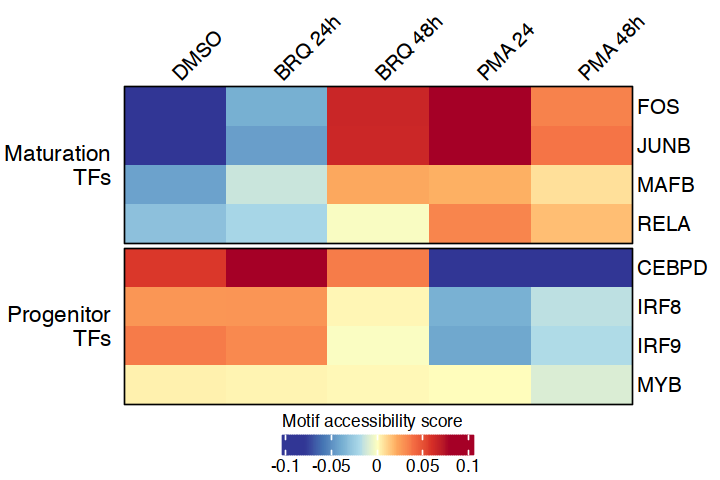

In [5]:
# Selected motifs only

motifs_of_interest = c("FOS", "JUNB", "MAFB", "RELA", "CEBPD", "IRF8", "IRF9", "MYB")

options(repr.plot.width=6, repr.plot.height=4)
h = Heatmap(dev_human_vals_mean[motifs_of_interest,], 
        cluster_columns = F, 
        cluster_rows = F,
        column_names_side = "top", 
        column_names_rot = 45,
        border=T,
        row_split = c(rep("Maturation\nTFs", 4), rep("Progenitor\nTFs", 4)),
        row_title_rot=0,
        col = colorRamp2(seq(-0.08, 0.08, length.out = 9), 
                         rev(RColorBrewer::brewer.pal(name = "RdYlBu", n = 11))[c(1:4, 6, 8:11)]),
       heatmap_legend_param = list(
                                   title="Motif accessibility score",
                                   direction="horizontal"))

draw(h, heatmap_legend_side="bottom")

pdf("../output/220426_thp1_selected_atac.pdf", width=4, height=3)
draw(h, heatmap_legend_side="bottom")
dev.off()


## Use ATACseq peaks as features for chromatin mods
Because the vast majority of binding events and active epigenetic marks occur at open chromatin, we calculate a master list of ATAC peaks across all the conditions

In [279]:
# extending summits by 25bp to allow intersection of similar summits
parallel -j 8 --dryrun "awk 'BEGIN {OFS=\"\t\"}; {print(\$1,\$2-25,\$3+25,\$4,\$5)}' {} > {.}_pm25.bed" ::: *_summits.bed

# get only peaks that are in both replicates for each timepoint, and take the peak from the first replicate
# peaks must overlap by at least half  
parallel -j 8 "bedtools intersect -a THP1_{}_rep1_ATACseq_peaks.narrowPeak \
-b THP1_{}_rep2_ATACseq_peaks.narrowPeak -f 0.5 -r -wa > THP1_{}_peaks_comb.bed" ::: DMSO BRQ24 BRQ48 PMA24  PMA48

# make a single file of all peaks, disallowing 50bp overlap
cat THP1*_peaks_comb.bed | sort -k1,1 -k2,2n | bedtools merge -i - -d 50 > ../../intermediate_files/THP1_all_peaks.bed
awk 'BEGIN {{OFS="\t"; print("GeneID", "Chr", "Start", "End", "Strand")}}; \
      {{print("peak" NR,$1,$2,$3,"+")}}' ../../intermediate_files/THP1_all_peaks.bed > \
      ../../intermediate_files/THP1_all_peaks.saf

# featureCounts
# -p is paired-end, -T is threads, -O is allowing multi overlap, -M is a multimapper, 
# --fraction relates to both -M and -O
featureCounts -T 10 -p -O -M --fraction -F SAF -a \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/intermediate_files/THP1_all_peaks.saf \
-o 220226_thp1_atac_k27ac_counts.txt \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/THP1_DMSO_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/THP1_DMSO_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/THP1_BRQ24_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/THP1_BRQ24_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/THP1_BRQ48_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/THP1_BRQ48_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/THP1_PMA24_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/THP1_PMA24_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/THP1_PMA48_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/THP1_PMA48_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/cutandrun_analysis/results/bowtie2_bam/THP_DMSO_H3K27ac_aligned_sorted.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/cutandrun_analysis/results/bowtie2_bam/THP_BRQ_24h_H3K27ac_aligned_sorted.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/cutandrun_analysis/results/bowtie2_bam/THP_BRQ_48h_H3K27ac_aligned_sorted.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/cutandrun_analysis/results/bowtie2_bam/THP_PMA_24h_H3K27ac_aligned_sorted.bam \
/net/rowley/ifs/data/vanderheiden/briando/differentiation_manuscript/cutandrun_analysis/results/bowtie2_bam/THP_PMA_48h_H3K27ac_aligned_sorted.bam



ERROR: Error in parse(text = x, srcfile = src): <text>:2:13: unexpected numeric constant
1: # extending summits by 25bp to allow intersection of similar summits
2: parallel -j 8
               ^


## Read in count file and get differential peaks

In [5]:
df = read.table("../data/220612_thp1_atac_k27ac_pu1_mll_at_atac.txt", header = TRUE, row.names=1)
peak_info = df[,1:5]
df = df[,6:dim(df)[2]]
colnames(df) = c("dmso_r1", "dmso_r2", "b24_r1", "b24_r2", "b48_r1", "b48_r2", "p24_r1", "p24_r2",
"p48_r1", "p48_r2", "d_k27ac", "b24_k27ac", "b48_k27ac", "p24_k27ac", "p48_k27ac",
"d_k27ac_new", "h4_k27ac_new", "b4_k27ac_new", "p4_k27ac_new", "b24_k27ac_new", "p24_k27ac_new",
"d_pu1", "b24_pu1", "b48_pu1", "p24_pu1", "p48_pu1",
"d_mll1", "b24_mll1", "p24_mll1", "d_mll3", "b24_mll3", "p24_mll3")
head(df)

,dmso_r1,dmso_r2,b24_r1,b24_r2,b48_r1,b48_r2,p24_r1,p24_r2,p48_r1,p48_r2,⋯,b24_pu1,b48_pu1,p24_pu1,p48_pu1,d_mll1,b24_mll1,p24_mll1,d_mll3,b24_mll3,p24_mll3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak1,3,7,21.5,3,61.5,56.5,33,32,114.5,69,⋯,9.5,31,34,33.5,2.5,2,5.5,6.5,5,3.5
peak2,4,24,24.5,13,42.5,37.5,49,28,122.5,79,⋯,46.5,49,79,93.5,17.5,11,25.5,8.5,7,3.5
peak3,0,0,4.0,3,58.0,73.0,12,8,18.0,15,⋯,12.0,54,34,41.0,0.0,10,5.0,5.0,5,5.0
peak4,38,135,224.0,104,307.0,327.0,229,175,328.0,204,⋯,139.0,137,196,146.0,38.0,88,76.0,9.0,14,8.0
peak5,99,265,153.0,74,190.0,207.0,142,116,204.0,146,⋯,54.0,42,80,68.0,77.0,105,86.0,18.0,14,3.0
peak6,6,21,7.0,6,3.0,6.0,5,7,19.0,10,⋯,7.0,1,5,6.0,7.0,2,2.0,2.0,1,2.0


In [3]:
# peak_info_bed = peak_info[,1:3]
# peak_info_bed$peak_name = row.names(peak_info)
# write.table(peak_info_bed, "../output/220527_thp1_all_peak_info.bed", sep='\t', row.names=F, col.names=F, quote=F)

In [6]:
# differential peaks
d0 <- DGEList(df[,1:10])
d0 <- calcNormFactors(d0, method="TMM")
#cutoff <- 
#drop <- which(apply(cpm(d0), 1, max) < cutoff)
#d <- d0[-drop,] 
dim(d0) # number of genes left

[1] 173612     10

In [7]:
# conditions for differential peak calling
conds = as.character(sapply(names(df[,1:10]), function(x) strsplit(x,'_')[[1]][1]))
conds

[1] "dmso" "dmso" "b24"  "b24"  "b48"  "b48"  "p24"  "p24"  "p48"  "p48"

,condsb24,condsb48,condsdmso,condsp24,condsp48
peak1,0.5911298,2.178687,-0.5799887,1.8694631,3.1875150
peak2,1.3056033,1.619708,0.7867153,2.0934880,3.3261346
peak3,-0.9950035,2.333456,-3.8132057,0.2177538,0.7491865
peak4,4.4113695,4.601466,3.4018936,4.4906321,4.7202606
peak5,3.8835723,3.927965,4.4927638,3.8474068,4.1237437
peak6,-0.2298085,-1.428373,0.7772551,-0.5210279,0.5623759


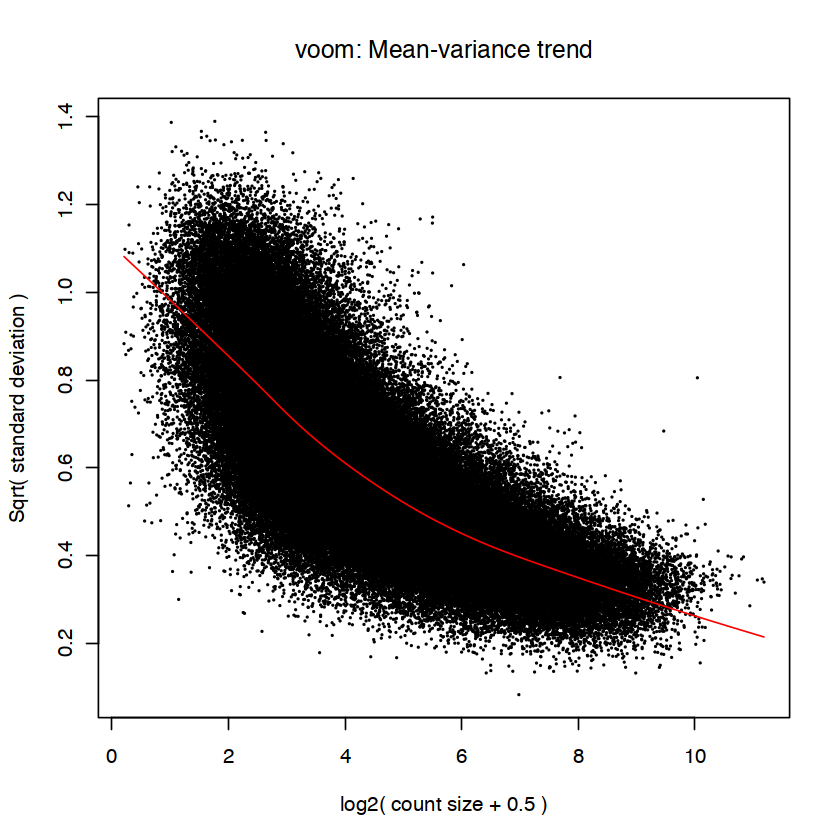

In [8]:
# normalize
mm <- model.matrix(~0 + conds)
y <- voom(d0, mm, plot = T)
fit <- lmFit(y, mm)
head(coef(fit))

In [9]:
# atac norm
atac_norm = as.data.frame(y$E)
head(atac_norm)

,dmso_r1,dmso_r2,b24_r1,b24_r2,b48_r1,b48_r2,p24_r1,p24_r2,p48_r1,p48_r2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak1,-0.1973461,-0.7148198,1.0135616,-0.4024880,2.355727,2.021460,1.7429456,2.02403258,3.2663676,3.0831360
peak2,0.1652239,0.9929995,1.1979862,1.5450446,1.827795,1.436497,2.3062130,1.83455478,3.3633920,3.2770779
peak3,-3.0047011,-4.6217104,-1.2759450,-0.4024880,2.271895,2.388242,0.3207126,0.08912761,0.6303309,0.9183913
peak4,3.2620855,3.4604387,4.3647016,4.4975162,4.665973,4.543921,4.5192068,4.45699199,4.7806271,4.6401520
peak5,4.6319236,4.4308577,3.8162248,4.0093256,3.975178,3.885537,3.8316745,3.86585091,4.0968346,4.1589518
peak6,0.6957387,0.8045544,-0.5389794,0.4905968,-1.791115,-1.110991,-0.8637120,-0.09144464,0.7062797,0.3565124


In [10]:
# get differentially accessible peaks for each condition
process_res = function(res) {
    tmp <- contrasts.fit(fit, res)
    tmp <- eBayes(tmp)
    res <- topTable(tmp, sort.by = "P", n = Inf)
    return(res)
}

p24_dep = process_res(makeContrasts("condsp24 - condsdmso", levels = colnames(coef(fit))))
p48_dep = process_res(makeContrasts("condsp48 - condsdmso", levels = colnames(coef(fit))))
p_dep = list(p24_dep, p48_dep)

b24_dep = process_res(makeContrasts("condsb24 - condsdmso", levels = colnames(coef(fit))))
b48_dep = process_res(makeContrasts("condsb48 - condsdmso", levels = colnames(coef(fit))))
b_dep = list(b24_dep, b48_dep)


In [11]:
# get BRQ up and down
brq_chg = list()
pma_chg = list()
shared_chg = list()

for (tp in 1:2) {
    res = b_dep[[tp]]
    up = rownames(res[res$logFC > 1 & res$adj.P.Val < 0.05,])
    down = rownames(res[res$logFC < -1 & res$adj.P.Val < 0.05,])
    brq_chg[[tp]] = c(length(up), length(down))

    res2 = p_dep[[tp]]
    up2 = rownames(res2[res2$logFC > 1 & res2$adj.P.Val < 0.05,])
    down2 = rownames(res2[res2$logFC < -1 & res2$adj.P.Val < 0.05,])
    pma_chg[[tp]] = c(length(up2), length(down2))
    
    shared_chg[[tp]] = c(length(intersect(up, up2)), length(intersect(down, down2)))
}

In [17]:
# get number of diff peaks
nums = c(c(0,0), unlist(brq_chg), c(0,0), unlist(pma_chg), c(0,0), unlist(shared_chg))
tp = rep(c(0, 0, 24, 24, 48, 48), 3)
tx = c(rep("BRQ", 6), rep("PMA", 6), rep("Shared", 6))
dir = rep(c("up", "down"), 9)
df_chg = as.data.frame(cbind(nums, tp, tx, dir))
df_chg$nums = as.numeric(df_chg$nums)
df_chg[df_chg$dir == "down", ]$nums = -1 * df_chg[df_chg$dir == "down", ]$nums
df_chg$tx = factor(df_chg$tx, levels=c("Shared", "BRQ", "PMA"))
df_chg

nums,tp,tx,dir
<dbl>,<chr>,<fct>,<chr>
0,0,BRQ,up
0,0,BRQ,down
14141,24,BRQ,up
-5801,24,BRQ,down
35015,48,BRQ,up
-21520,48,BRQ,down
0,0,PMA,up
0,0,PMA,down
40757,24,PMA,up


## Annotate peaks

In [13]:
## Annotate everything
# get GRanges object for all my peaks
peak_ranges = GRanges(seqnames=peak_info$Chr,
                      ranges=IRanges(start=peak_info$Start,
                                     end=peak_info$End),
                      peak_id=rownames(peak_info))
peak_ranges


GRanges object with 173612 ranges and 1 metadata column:
           seqnames            ranges strand |     peak_id
              <Rle>         <IRanges>  <Rle> | <character>
       [1]     chr1     807052-807600      * |       peak1
       [2]     chr1     807670-808321      * |       peak2
       [3]     chr1     810868-811240      * |       peak3
       [4]     chr1     817208-817986      * |       peak4
       [5]     chr1     826704-827907      * |       peak5
       ...      ...               ...    ... .         ...
  [173608]     chrY 24323656-24323856      * |  peak173608
  [173609]     chrY 24325879-24326103      * |  peak173609
  [173610]     chrY 25348349-25348999      * |  peak173610
  [173611]     chrY 26359937-26360180      * |  peak173611
  [173612]     chrY 26563026-26563374      * |  peak173612
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [14]:
# annotate all 171k peaks
txdb = TxDb.Hsapiens.UCSC.hg38.knownGene
# peakAnno <- as.data.frame(annotatePeak(peak_ranges, tssRegion=c(-2000, 500),
#                      TxDb=txdb, annoDb="org.Hs.eg.db"))
peakAnno <- as.data.frame(annotatePeak(peak_ranges, tssRegion=c(-2000, 2000),
                     TxDb=txdb, annoDb="org.Hs.eg.db"))
peakAnno$annobrief = sapply(peakAnno$annotation, function(x) strsplit(x, ' ') [[1]][1])
peakAnno$annobrief[peakAnno$annobrief == "5'"] = "5' UTR"
peakAnno$annobrief[peakAnno$annobrief == "3'"] = "3' UTR"
peakAnno$annobrief[peakAnno$annobrief == "Distal"] = "Intergenic"
peakAnno$annobrief[peakAnno$annobrief == "Downstream"] = "TTS"
head(peakAnno)

>> preparing features information...		 2024-03-28 15:34:40 
>> identifying nearest features...		 2024-03-28 15:34:41 
>> calculating distance from peak to TSS...	 2024-03-28 15:34:42 
>> assigning genomic annotation...		 2024-03-28 15:34:42 
>> adding gene annotation...			 2024-03-28 15:34:58 


Loading required package: org.Hs.eg.db



'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2024-03-28 15:34:58 
>> done...					 2024-03-28 15:34:58 


,seqnames,start,end,width,strand,peak_id,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME,annobrief
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,chr1,807052,807600,549,*,peak1,"Exon (ENST00000412115.2/105378580, exon 4 of 5)",1,803934,807435,3502,1,105378580,ENST00000667728.1,3118,ENSG00000237491,LINC01409,long intergenic non-protein coding RNA 1409,Exon
2,chr1,807670,808321,652,*,peak2,"Exon (ENST00000443772.2/105378580, exon 4 of 4)",1,803934,807435,3502,1,105378580,ENST00000667728.1,3736,ENSG00000237491,LINC01409,long intergenic non-protein coding RNA 1409,Exon
3,chr1,810868,811240,373,*,peak3,"Intron (ENST00000635509.2/105378947, intron 1 of 3)",1,817371,819837,2467,1,400728,ENST00000326734.2,-6131,ENSG00000177757,FAM87B,family with sequence similarity 87 member B,Intron
4,chr1,817208,817986,779,*,peak4,Promoter (<=1kb),1,817371,819837,2467,1,400728,ENST00000326734.2,0,ENSG00000177757,FAM87B,family with sequence similarity 87 member B,Promoter
5,chr1,826704,827907,1204,*,peak5,Promoter (<=1kb),1,594308,827769,233462,2,105378947,ENST00000635509.2,0,NA,LOC105378947,proline-rich extensin-like protein EPR1,Promoter
6,chr1,838302,838622,321,*,peak6,"Intron (ENST00000624927.3/643837, intron 1 of 2)",1,831605,842020,10416,1,643837,ENST00000415295.1,6697,ENSG00000228794,LINC01128,long intergenic non-protein coding RNA 1128,Intron


In [15]:
# Promoter peaks
prom_peaks = subset(peakAnno, annobrief == "Promoter")
rownames(prom_peaks) = prom_peaks$peak_id
head(prom_peaks)

,seqnames,start,end,width,strand,peak_id,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME,annobrief
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
peak4,chr1,817208,817986,779,*,peak4,Promoter (<=1kb),1,817371,819837,2467,1,400728,ENST00000326734.2,0,ENSG00000177757,FAM87B,family with sequence similarity 87 member B,Promoter
peak5,chr1,826704,827907,1204,*,peak5,Promoter (<=1kb),1,594308,827769,233462,2,105378947,ENST00000635509.2,0,NA,LOC105378947,proline-rich extensin-like protein EPR1,Promoter
peak7,chr1,851392,852052,661,*,peak7,Promoter (<=1kb),1,851348,852752,1405,1,643837,ENST00000425657.1,44,ENSG00000228794,LINC01128,long intergenic non-protein coding RNA 1128,Promoter
peak9,chr1,869669,870062,394,*,peak9,Promoter (<=1kb),1,868240,870201,1962,2,284593,ENST00000432963.1,139,ENSG00000230368,FAM41C,family with sequence similarity 41 member C,Promoter
peak10,chr1,876383,877318,936,*,peak10,Promoter (<=1kb),1,868071,876903,8833,2,284593,ENST00000446136.1,0,ENSG00000230368,FAM41C,family with sequence similarity 41 member C,Promoter
peak14,chr1,911189,911508,320,*,peak14,Promoter (<=1kb),1,911435,914948,3514,1,284600,ENST00000448179.1,0,NA,LOC284600,uncharacterized LOC284600,Promoter


In [16]:
# Enhancer peaks
enh_peaks = unique(subset(peakAnno, annobrief != "Promoter"))$peak_id
length(enh_peaks)

tss_peaks = unique(subset(peakAnno, annobrief == "Promoter"))$peak_id
length(tss_peaks)

[1] 138631

[1] 34981

In [17]:
# What is the baseline frequency of peaks in each genomic region?
baseline_freqs = data.frame(table(peakAnno[which(peakAnno$peak_id %in% rownames(b48_dep)),]$annobrief))
baseline_cts = baseline_freqs
baseline_freqs$Freq = baseline_freqs$Freq/sum(baseline_freqs$Freq)*100
baseline_freqs

Var1,Freq
<fct>,<dbl>
3' UTR,1.9883418
5' UTR,0.2240629
Exon,3.7871806
Intergenic,30.7461466
Intron,42.9883879
Promoter,20.1489528
TTS,0.1169274


In [24]:
# Calculating frequency and counts for each set of differentially expressed peaks
res = b24_dep
up_peaks_brq = rownames(res[res$logFC > 1.5 & res$adj.P.Val < 0.05,])
down_peaks_brq = rownames(res[res$logFC < -1.5 & res$adj.P.Val < 0.05,])
up_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% up_peaks_brq),]$annobrief))$Freq
baseline_freqs$brq24_up = up_freq/sum(up_freq)*100
baseline_cts$brq24_up = up_freq
down_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% down_peaks_brq),]$annobrief))$Freq
baseline_freqs$brq24_down = down_freq/sum(down_freq)*100
baseline_cts$brq24_down = down_freq

baseline_cts$brq24 = up_freq + down_freq
baseline_freqs$brq24  = baseline_cts$brq24/sum(baseline_cts$brq24) * 100

res = b48_dep
up_peaks_brq = rownames(res[res$logFC > 1.5 & res$adj.P.Val < 0.05,])
down_peaks_brq = rownames(res[res$logFC < -1.5 & res$adj.P.Val < 0.05,])
up_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% up_peaks_brq),]$annobrief))$Freq
baseline_freqs$brq_up = up_freq/sum(up_freq)*100
baseline_cts$brq_up = up_freq
down_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% down_peaks_brq),]$annobrief))$Freq
baseline_freqs$brq48_down = down_freq/sum(down_freq)*100
baseline_cts$brq48_down = down_freq

baseline_cts$brq48 = up_freq + down_freq
baseline_freqs$brq48  = baseline_cts$brq48/sum(baseline_cts$brq48) * 100

res = p24_dep
up_peaks_pma = rownames(res[res$logFC > 1.5 & res$adj.P.Val < 0.05,])
down_peaks_pma = rownames(res[res$logFC < -1.5 & res$adj.P.Val < 0.05,])
up_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% up_peaks_pma),]$annobrief))$Freq
baseline_freqs$pma24_up = up_freq/sum(up_freq)*100
baseline_cts$pma24_up = up_freq
down_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% down_peaks_pma),]$annobrief))$Freq
baseline_freqs$pma24_down = down_freq/sum(down_freq)*100
baseline_cts$pma24_down = down_freq

baseline_cts$pma24 = up_freq + down_freq
baseline_freqs$pma24  = baseline_cts$pma24/sum(baseline_cts$pma24) * 100

res = p48_dep
up_peaks_pma = rownames(res[res$logFC > 1.5 & res$adj.P.Val < 0.05,])
down_peaks_pma = rownames(res[res$logFC < -1.5 & res$adj.P.Val < 0.05,])
up_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% up_peaks_pma),]$annobrief))$Freq
baseline_freqs$pma48_up = up_freq/sum(up_freq)*100
baseline_cts$pma48_up = up_freq
down_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% down_peaks_pma),]$annobrief))$Freq
baseline_freqs$pma48_down = down_freq/sum(down_freq)*100
baseline_cts$pma48_down = down_freq

baseline_cts$pma48 = up_freq + down_freq
baseline_freqs$pma48  = baseline_cts$pma48/sum(baseline_cts$pma48) * 100


rownames(baseline_freqs) = baseline_freqs[,1]
rownames(baseline_cts) = baseline_cts[,1]
baseline_freqs = baseline_freqs[,2:dim(baseline_freqs)[2]]
baseline_cts = baseline_cts[,2:dim(baseline_cts)[2]]

baseline_freqs
baseline_cts

,Freq,brq24_up,brq24_down,brq24,brq_up,brq48_down,brq48,pma24_up,pma24_down,pma24,pma48_up,pma48_down,pma48
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3' UTR,1.9883418,1.8882566,2.1046951,1.9300991,1.70217927,2.3016299,1.88863200,1.7845922,2.1928605,1.9495112,1.7175736,2.2532907,1.9506041
5' UTR,0.2240629,0.2457320,0.2698327,0.2503912,0.16981361,0.2149382,0.18384913,0.2450672,0.2318034,0.2397094,0.2146967,0.2230981,0.2183512
Exon,3.7871806,3.6730471,3.8316244,3.7037037,3.62269033,3.5196131,3.59062927,3.8393867,3.4492350,3.6817858,3.5725532,3.7963858,3.6699177
Intergenic,30.7461466,30.3155717,34.4306530,31.1111111,33.46136740,29.7331184,32.30173542,31.3151942,34.3532684,32.5424173,31.5632783,34.1823455,32.7025410
Intron,42.9883879,52.4831868,42.8494334,50.6207616,50.38612380,48.7461938,49.87604112,49.4407440,48.1780250,48.9306716,50.4336873,47.3637243,49.0982904
Promoter,20.1489528,11.2519400,16.2978953,12.2274387,10.57696195,15.3770374,12.06997409,13.2587659,11.4649977,12.5341773,12.3894312,12.0212687,12.2292849
TTS,0.1169274,0.1422659,0.2158662,0.1564945,0.08086362,0.1074691,0.08913897,0.1162498,0.1298099,0.1217274,0.1087797,0.1598870,0.1310107


,Freq,brq24_up,brq24_down,brq24,brq_up,brq48_down,brq48,pma24_up,pma24_down,pma24,pma48_up,pma48_down,pma48
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
3' UTR,3452,146,39,185,421,257,678,568,473,1041,600,606,1206
5' UTR,389,19,5,24,42,24,66,78,50,128,75,60,135
Exon,6575,284,71,355,896,393,1289,1222,744,1966,1248,1021,2269
Intergenic,53379,2344,638,2982,8276,3320,11596,9967,7410,17377,11026,9193,20219
Intron,74633,4058,794,4852,12462,5443,17905,15736,10392,26128,17618,12738,30356
Promoter,34981,870,302,1172,2616,1717,4333,4220,2473,6693,4328,3233,7561
TTS,203,11,4,15,20,12,32,37,28,65,38,43,81


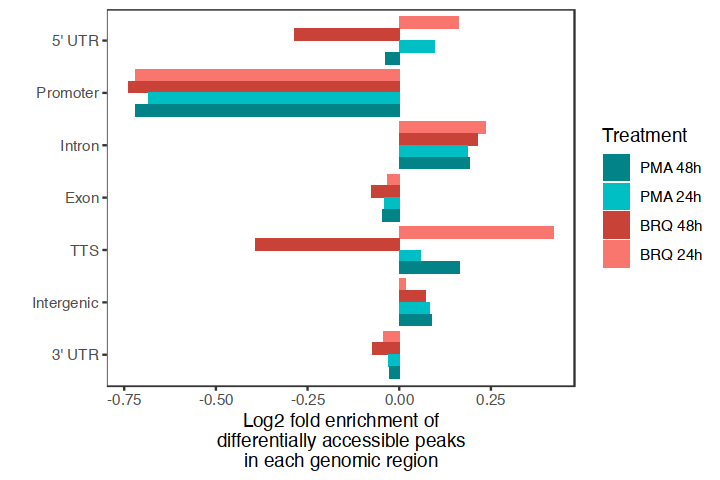

In [25]:
# Calculating log2 fold change for each region/sample 
log2_region_changes = log2(with(baseline_freqs, cbind(brq24/Freq, brq48/Freq, pma24/Freq, pma48/Freq)))
rownames(log2_region_changes) = rownames(baseline_freqs)
colnames(log2_region_changes) = c("BRQ 24h", "BRQ 48h", "PMA 24h", "PMA 48h")
log2_region_changes_m = melt(log2_region_changes)
colnames(log2_region_changes_m) = c("Region", "Treatment", "log2fc")
log2_region_changes_m$Region = factor(log2_region_changes_m$Region, levels=
rev(c("5' UTR", "Promoter", "Intron", "Exon", "TTS", "Intergenic", "3' UTR")))
log2_region_changes_m$Treatment = factor(log2_region_changes_m$Treatment, levels=rev(c("BRQ 24h", "BRQ 48h", "PMA 24h", "PMA 48h")))

ggplot(data = log2_region_changes_m, aes(x=Region, y=log2fc, fill=Treatment)) + 
geom_col(position = "dodge") + theme_bw() + theme(panel.grid.major = element_blank(),
panel.grid.minor = element_blank()) + coord_flip() + geom_vline(xintercept=0) +
ylab("Log2 fold enrichment of\ndifferentially accessible peaks\nin each genomic region") +
xlab("") + scale_fill_manual(values = c("BRQ 24h" = "#F8766D",
                                "BRQ 48h"="#c94238",
                                "PMA 24h"="#00BFC4",
                                "PMA 48h"="#018388")) 

#ggsave("../output/220510_thp1_atac_dapeaks_enrichment.pdf", width=4, height=4)

In [26]:
# Calculating frequency and counts for each set of differentially expressed peaks
res = b24_dep
up_peaks_brq = rownames(res[res$logFC > 1.5 & res$adj.P.Val < 0.05,])
down_peaks_brq = rownames(res[res$logFC < -1.5 & res$adj.P.Val < 0.05,])
up_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% up_peaks_brq),]$annobrief))$Freq
baseline_freqs$brq24_up = up_freq/sum(up_freq)*100
baseline_cts$brq24_up = up_freq
down_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% down_peaks_brq),]$annobrief))$Freq
baseline_freqs$brq24_down = down_freq/sum(down_freq)*100
baseline_cts$brq24_down = down_freq

baseline_cts$brq24 = up_freq + down_freq
baseline_freqs$brq24  = baseline_cts$brq24/sum(baseline_cts$brq24) * 100

res = b48_dep
up_peaks_brq = rownames(res[res$logFC > 1.5 & res$adj.P.Val < 0.05,])
down_peaks_brq = rownames(res[res$logFC < -1.5 & res$adj.P.Val < 0.05,])
up_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% up_peaks_brq),]$annobrief))$Freq
baseline_freqs$brq_up = up_freq/sum(up_freq)*100
baseline_cts$brq_up = up_freq
down_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% down_peaks_brq),]$annobrief))$Freq
baseline_freqs$brq48_down = down_freq/sum(down_freq)*100
baseline_cts$brq48_down = down_freq

baseline_cts$brq48 = up_freq + down_freq
baseline_freqs$brq48  = baseline_cts$brq48/sum(baseline_cts$brq48) * 100

res = p24_dep
up_peaks_pma = rownames(res[res$logFC > 1.5 & res$adj.P.Val < 0.05,])
down_peaks_pma = rownames(res[res$logFC < -1.5 & res$adj.P.Val < 0.05,])
up_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% up_peaks_pma),]$annobrief))$Freq
baseline_freqs$pma24_up = up_freq/sum(up_freq)*100
baseline_cts$pma24_up = up_freq
down_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% down_peaks_pma),]$annobrief))$Freq
baseline_freqs$pma24_down = down_freq/sum(down_freq)*100
baseline_cts$pma24_down = down_freq

baseline_cts$pma24 = up_freq + down_freq
baseline_freqs$pma24  = baseline_cts$pma24/sum(baseline_cts$pma24) * 100

res = p48_dep
up_peaks_pma = rownames(res[res$logFC > 1.5 & res$adj.P.Val < 0.05,])
down_peaks_pma = rownames(res[res$logFC < -1.5 & res$adj.P.Val < 0.05,])
up_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% up_peaks_pma),]$annobrief))$Freq
baseline_freqs$pma48_up = up_freq/sum(up_freq)*100
baseline_cts$pma48_up = up_freq
down_freq = data.frame(table(peakAnno[which(peakAnno$peak_id %in% down_peaks_pma),]$annobrief))$Freq
baseline_freqs$pma48_down = down_freq/sum(down_freq)*100
baseline_cts$pma48_down = down_freq

baseline_cts$pma48 = up_freq + down_freq
baseline_freqs$pma48  = baseline_cts$pma48/sum(baseline_cts$pma48) * 100


rownames(baseline_freqs) = baseline_freqs[,1]
rownames(baseline_cts) = baseline_cts[,1]
baseline_freqs = baseline_freqs[,2:dim(baseline_freqs)[2]]
baseline_cts = baseline_cts[,2:dim(baseline_cts)[2]]

baseline_freqs
baseline_cts

,brq24_up,brq24_down,brq24,brq_up,brq48_down,brq48,pma24_up,pma24_down,pma24,pma48_up,pma48_down,pma48
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.98834181968988,1.8882566,2.1046951,1.9300991,1.70217927,2.3016299,1.88863200,1.7845922,2.1928605,1.9495112,1.7175736,2.2532907,1.9506041
0.224062852798194,0.2457320,0.2698327,0.2503912,0.16981361,0.2149382,0.18384913,0.2450672,0.2318034,0.2397094,0.2146967,0.2230981,0.2183512
3.78718060963528,3.6730471,3.8316244,3.7037037,3.62269033,3.5196131,3.59062927,3.8393867,3.4492350,3.6817858,3.5725532,3.7963858,3.6699177
30.7461465797295,30.3155717,34.4306530,31.1111111,33.46136740,29.7331184,32.30173542,31.3151942,34.3532684,32.5424173,31.5632783,34.1823455,32.7025410
42.988387899454,52.4831868,42.8494334,50.6207616,50.38612380,48.7461938,49.87604112,49.4407440,48.1780250,48.9306716,50.4336873,47.3637243,49.0982904
20.1489528373615,11.2519400,16.2978953,12.2274387,10.57696195,15.3770374,12.06997409,13.2587659,11.4649977,12.5341773,12.3894312,12.0212687,12.2292849
0.116927401331705,0.1422659,0.2158662,0.1564945,0.08086362,0.1074691,0.08913897,0.1162498,0.1298099,0.1217274,0.1087797,0.1598870,0.1310107


,brq24_up,brq24_down,brq24,brq_up,brq48_down,brq48,pma24_up,pma24_down,pma24,pma48_up,pma48_down,pma48
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
3452,146,39,185,421,257,678,568,473,1041,600,606,1206
389,19,5,24,42,24,66,78,50,128,75,60,135
6575,284,71,355,896,393,1289,1222,744,1966,1248,1021,2269
53379,2344,638,2982,8276,3320,11596,9967,7410,17377,11026,9193,20219
74633,4058,794,4852,12462,5443,17905,15736,10392,26128,17618,12738,30356
34981,870,302,1172,2616,1717,4333,4220,2473,6693,4328,3233,7561
203,11,4,15,20,12,32,37,28,65,38,43,81


In [27]:
# Calculating log2 fold change for each region/sample 
log2_region_changes = log2(with(baseline_freqs, cbind(brq24/Freq, brq48/Freq, pma24/Freq, pma48/Freq)))
rownames(log2_region_changes) = rownames(baseline_freqs)
colnames(log2_region_changes) = c("BRQ 24h", "BRQ 48h", "PMA 24h", "PMA 48h")
log2_region_changes_m = melt(log2_region_changes)
colnames(log2_region_changes_m) = c("Region", "Treatment", "log2fc")
log2_region_changes_m$Region = factor(log2_region_changes_m$Region, levels=
rev(c("5' UTR", "Promoter", "Intron", "Exon", "TTS", "Intergenic", "3' UTR")))
log2_region_changes_m$Treatment = factor(log2_region_changes_m$Treatment, levels=rev(c("BRQ 24h", "BRQ 48h", "PMA 24h", "PMA 48h")))

ggplot(data = log2_region_changes_m, aes(x=Region, y=log2fc, fill=Treatment)) + 
geom_col(position = "dodge") + theme_bw() + theme(panel.grid.major = element_blank(),
panel.grid.minor = element_blank()) + coord_flip() + geom_vline(xintercept=0) +
ylab("Log2 fold enrichment of\ndifferentially accessible peaks\nin each genomic region") +
xlab("") + scale_fill_manual(values = c("BRQ 24h" = "#F8766D",
                                "BRQ 48h"="#c94238",
                                "PMA 24h"="#00BFC4",
                                "PMA 48h"="#018388")) 

#ggsave("../output/220510_thp1_atac_dapeaks_enrichment.pdf", width=4, height=4)

ERROR: Error in eval(quote(list(...)), env): object 'Freq' not found


## ATAC at TSS

In [ ]:
dim(subset(p48_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(p48_dep) %in% tss_peaks))
dim(subset(p48_dep, logFC < -1 & adj.P.Val < 0.05))

dim(subset(b48_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(b48_dep) %in% tss_peaks))
dim(subset(b48_dep, logFC < -1 &d adj.P.Val < 0.05))

dim(subset(p24_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(p24_dep) %in% tss_peaks))
dim(subset(p24_dep, logFC < -1 & adj.P.Val < 0.05))

dim(subset(b24_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(b24_dep) %in% tss_peaks))
dim(subset(b24_dep, logFC < -1 & adj.P.Val < 0.05))

dim(subset(p48_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(p48_dep) %in% tss_peaks))
dim(subset(p48_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(b48_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(b48_dep) %in% tss_peaks))
dim(subset(b48_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(p24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(p24_dep) %in% tss_peaks))
dim(subset(p24_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(b24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(b24_dep) %in% tss_peaks))
dim(subset(b24_dep, logFC > 1 & adj.P.Val < 0.05))

## Changes in ATAC

In [ ]:
get_freq = function(x) {
    return(table(x$annobrief)/dim(x)[1])
}
exp = get_freq(peakAnno)

# Frequency
b24_freq = log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(b24_dep, abs(logFC) > 1 & adj.P.Val < 0.05))))/exp)
b48_freq = log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(b48_dep, abs(logFC) > 1 & adj.P.Val < 0.05))))/exp)
p24_freq = log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(p24_dep, abs(logFC) > 1 & adj.P.Val < 0.05))))/exp)
p48_freq = log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(p48_dep, abs(logFC) > 1 & adj.P.Val < 0.05))))/exp)

# Numbers
b24_cts = table(subset(peakAnno, peak_id %in% rownames(subset(b24_dep, abs(logFC) > 1 & adj.P.Val < 0.05)))$annobrief)
b48_cts = table(subset(peakAnno, peak_id %in% rownames(subset(b48_dep, abs(logFC) > 1 & adj.P.Val < 0.05)))$annobrief)
p24_cts = table(subset(peakAnno, peak_id %in% rownames(subset(p24_dep, abs(logFC) > 1 & adj.P.Val < 0.05)))$annobrief)
p48_cts = table(subset(peakAnno, peak_id %in% rownames(subset(p48_dep, abs(logFC) > 1 & adj.P.Val < 0.05)))$annobrief)

In [ ]:

# processing dfs
freqs = cbind(b24_freq, b48_freq, p24_freq,p48_freq)
colnames(freqs) = c("BRQ 24h", "BRQ 48h", "PMA 24h", "PMA 48h")
cts = cbind(b24_cts, b48_cts, p24_cts, p48_cts)
colnames(cts) = c("BRQ 24h", "BRQ 48h", "PMA 24h", "PMA 48h")
freqs = melt(freqs)
cts = melt(cts)

# combine them 
freq_ct_df = cbind(freqs, cts[,3])
colnames(freq_ct_df) = c("region", "tx", "log2 Obs/Exp", "Number of peaks")

# plotting
ggplot(freq_ct_df, aes(x=tx, y = region, fill = `log2 Obs/Exp`, size = `Number of peaks`)) + 
geom_point(pch=21) + scale_fill_gradient2(low = "purple", mid = "white", high = "goldenrod",
                        limits=c(-.3,.3), oob = scales::squish) + # desired breaks on transformed scale
theme_bw() + xlab("") + scale_x_discrete(guide = guide_axis(angle = 45)) +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank())

#ggsave("../output/230921_thp_atac_changed_peaks.pdf", width=3.5, height=4)

## H3K27ac analysis

### With differential peak analysis

In [22]:
colnames(df)
colnames(df[,c(11,12,14,16,20,21)])

[1] "dmso_r1"       "dmso_r2"       "b24_r1"        "b24_r2"       
 [5] "b48_r1"        "b48_r2"        "p24_r1"        "p24_r2"       
 [9] "p48_r1"        "p48_r2"        "d_k27ac"       "b24_k27ac"    
[13] "b48_k27ac"     "p24_k27ac"     "p48_k27ac"     "d_k27ac_new"  
[17] "h4_k27ac_new"  "b4_k27ac_new"  "p4_k27ac_new"  "b24_k27ac_new"
[21] "p24_k27ac_new" "d_pu1"         "b24_pu1"       "b48_pu1"      
[25] "p24_pu1"       "p48_pu1"       "d_mll1"        "b24_mll1"     
[29] "p24_mll1"      "d_mll3"        "b24_mll3"      "p24_mll3"

[1] "d_k27ac"       "b24_k27ac"     "p24_k27ac"     "d_k27ac_new"  
[5] "b24_k27ac_new" "p24_k27ac_new"

In [23]:
# differential peaks
d0 <- DGEList(df[,c(11,12,14,16,20,21)])
d0 <- calcNormFactors(d0, method="TMM")
cutoff <- 2
drop <- which(apply(cpm(d0), 1, max) < cutoff)
d <- d0[-drop,] 
dim(d0) # number of genes left

[1] 173612      6

,condsb24,condsd24,condsp24,batchb
peak1,0.34398060,0.6904548,2.001275,0.6072168136
peak2,1.95807525,2.2730316,3.048988,0.7338767690
peak3,0.08445916,-0.1666306,1.745822,0.0932246735
peak4,3.67629831,2.7104401,3.785914,0.7925451881
peak5,4.38825948,4.5710831,4.357622,0.2925672614
peak7,1.83676898,1.1194069,1.195762,-0.0004164495


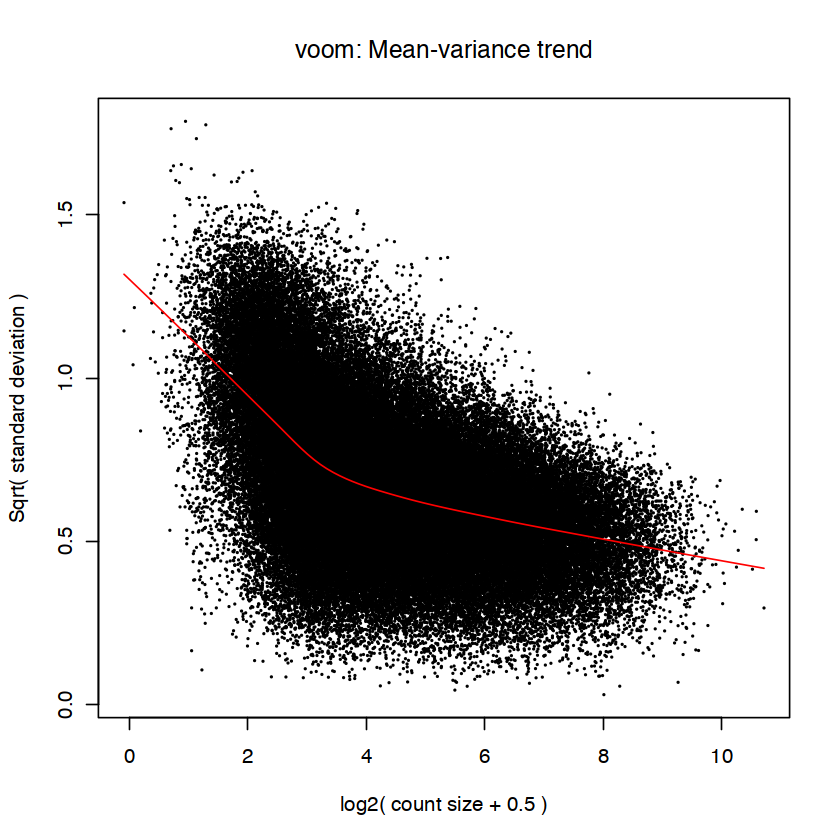

In [24]:
# conditions for differential peak calling
conds = rep(c("d24", "b24", "p24"), 2)
batch = c(rep("a",3), rep("b",3))

# normalize
mm <- model.matrix(~0 + conds + batch)
# mm <- model.matrix(~conds + batch)  # https://support.bioconductor.org/p/9143735/ apparently not having the zero is better
y <- voom(d, mm, plot = T)
fit <- lmFit(y, mm)
head(coef(fit))

k27ac_norm = as.data.frame(y$E)

In [25]:
# get differential K27ac peaks for each condition
process_res = function(res) {
    tmp <- contrasts.fit(fit, res)
    tmp <- eBayes(tmp)
    res <- topTable(tmp, sort.by = "P", n = Inf)
    return(res)
}

k27_p24_dep = process_res(makeContrasts("condsp24 - condsd24", levels = colnames(coef(fit))))
#k27_b24_dep = process_res(makeContrasts("-condsd24", levels = colnames(coef(fit))))
k27_b24_dep = process_res(makeContrasts("condsb24 - condsd24", levels = colnames(coef(fit))))


In [26]:
dim(subset(k27_b24_dep, logFC > 1 & adj.P.Val < 0.05))
dim(subset(k27_b24_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(k27_p24_dep, logFC > 1 & adj.P.Val < 0.05))
dim(subset(k27_p24_dep, logFC < -1 & adj.P.Val < 0.05))

[1] 4733    6

[1] 1816    6

[1] 19060     6

[1] 16285     6

In [33]:
saveRDS(list(k27_b24_dep, k27_p24_dep), "../output/230923_thp1_k27ac_b24_p24.rds")

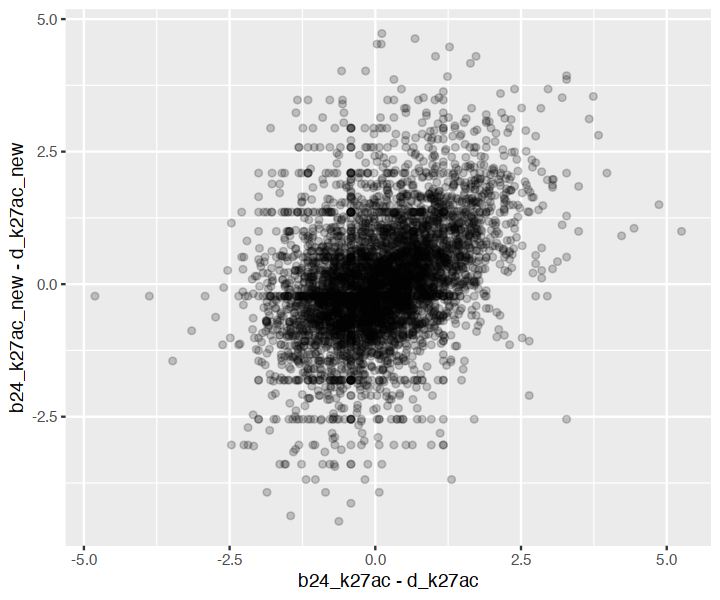

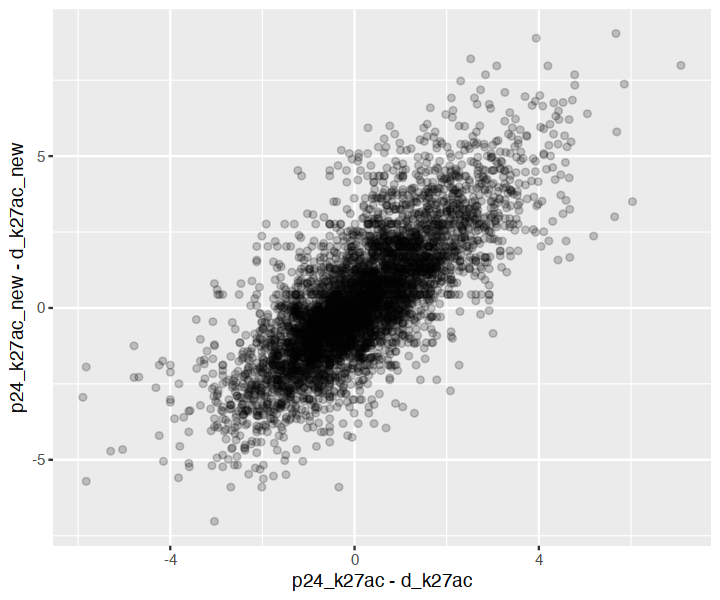

In [529]:
# it seems like there is more variability from expt to expt for BRQ - i am not sure why this is the case
ggplot(k27ac_norm[sample(1:dim(k27ac_norm)[1], 5000),], aes(x=b24_k27ac - d_k27ac, y=b24_k27ac_new - d_k27ac_new)) + geom_point(alpha=0.2)
ggplot(k27ac_norm[sample(1:dim(k27ac_norm)[1], 5000),], aes(x=p24_k27ac - d_k27ac, y=p24_k27ac_new - d_k27ac_new)) + geom_point(alpha=0.2)

In [27]:
# annotations of where changes in H3K27ac are
get_freq = function(x) {
    return(table(x$annobrief)/dim(x)[1])
}
exp = get_freq(peakAnno)

# Frequency
b24_freq = log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(k27_b24_dep, abs(logFC) > 1 & adj.P.Val < 0.05))))/exp)
p24_freq = log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(k27_p24_dep, abs(logFC) > 1 & adj.P.Val < 0.05))))/exp)

# Numbers
b24_cts = table(subset(peakAnno, peak_id %in% rownames(subset(k27_b24_dep, abs(logFC) > 1 & adj.P.Val < 0.05)))$annobrief)
p24_cts = table(subset(peakAnno, peak_id %in% rownames(subset(k27_p24_dep, abs(logFC) > 1 & adj.P.Val < 0.05)))$annobrief)

# processing dfs
freqs = cbind(b24_freq, p24_freq)
colnames(freqs) = c("BRQ", "PMA")
cts = cbind(b24_cts, p24_cts)
colnames(cts) = c("BRQ", "PMA")
freqs = melt(freqs)
cts = melt(cts)

# combine them 
freq_ct_df = cbind(freqs, cts[,3])
colnames(freq_ct_df) = c("region", "tx", "log2 Obs/Exp", "Number of peaks")
freq_ct_df

region,tx,log2 Obs/Exp,Number of peaks
<fct>,<fct>,<dbl>,<int>
3' UTR,BRQ,0.1147828317,141
5' UTR,BRQ,0.0317124791,15
Exon,BRQ,-0.0001306402,248
Intergenic,BRQ,-0.1974592998,1756
Intron,BRQ,-0.0608685684,2699
Promoter,BRQ,0.3492683261,1681
TTS,BRQ,0.2330373128,9
3' UTR,PMA,0.2260664573,822
5' UTR,PMA,0.3508737606,101


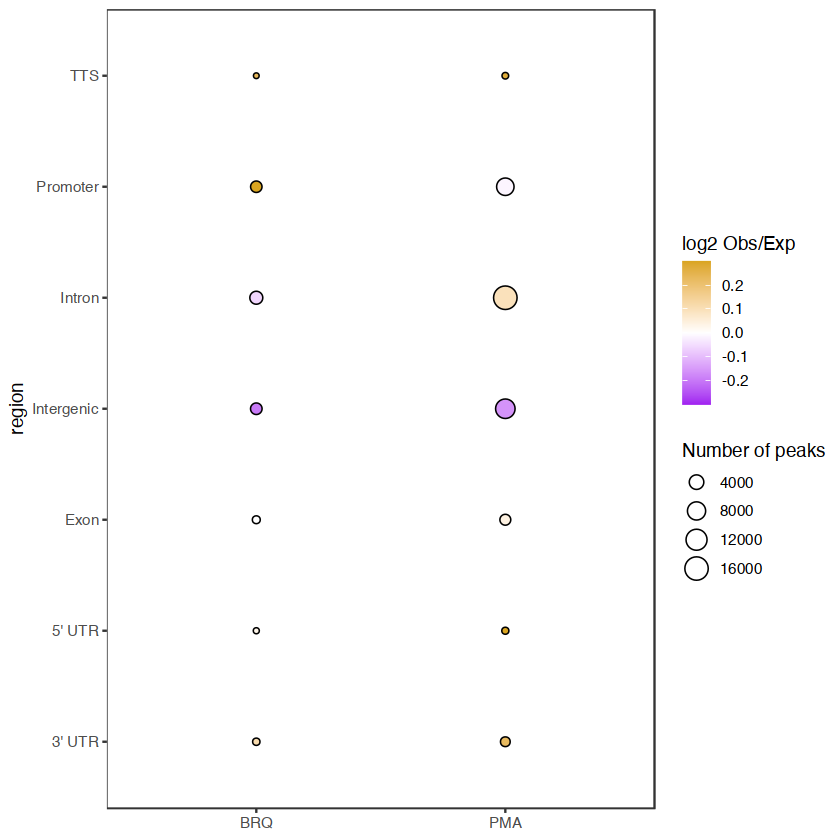

In [28]:
# plotting
ggplot(freq_ct_df, aes(x=tx, y = region, fill = `log2 Obs/Exp`, size = `Number of peaks`)) + 
geom_point(pch=21) + scale_fill_gradient2(low = "purple", mid = "white", high = "goldenrod",
                        limits=c(-.3,.3), oob = scales::squish) + # desired breaks on transformed scale
theme_bw() + 
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank(), axis.title.x = element_blank())

ggsave("../output/230921_thp1_k27ac_changed_peaks.pdf", width=3.5, height=3)

In [29]:
# processing region-gene associations from GREAT
great_data = read.table("../data/20220226-public-4.0.4-WIViwg-hg38-all-region.txt", sep='\t')
great_data = great_data[great_data$V2 != "NONE",]
great_data$gene = sapply(great_data$V2, function(x) strsplit(x, split = ' ')[[1]][1])
great_data$dist = sapply(great_data$V2, function(x) strsplit(x, split = ' ')[[1]][2])
great_data$dist = as.numeric(gsub('(', '', gsub(')', '', great_data$dist, fixed=T), fixed=T))
rownames(great_data) = great_data$V1
colnames(great_data) = c("peak_id", "great_output", "gene", "dist")
head(great_data)

,peak_id,great_output,gene,dist
,<chr>,<chr>,<chr>,<dbl>
peak10,peak10,SAMD11 (-48887),SAMD11,-48887
peak11,peak11,SAMD11 (-34756),SAMD11,-34756
peak12,peak12,SAMD11 (-21736),SAMD11,-21736
peak13,peak13,SAMD11 (-21146),SAMD11,-21146
peak14,peak14,SAMD11 (-14389),SAMD11,-14389
peak15,peak15,SAMD11 (-12725),SAMD11,-12725


In [39]:
# how many peaks that gained H3K27ac did not gain ATAC? [trying to just use FDR] 
# almost 30% of peaks in BRQ, compared to only 13% in PMA 

b = rownames(subset(k27_b24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(k27_b24_dep) %in% rownames(great_data)))
p = rownames(subset(k27_p24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(k27_p24_dep) %in% rownames(great_data)))

dim(subset(b24_dep[b,]))  # 4733
dim(subset(b24_dep[b,], adj.P.Val < 0.05 & logFC >= 1))  # 2280 sig more acc >1
dim(subset(b24_dep[b,], adj.P.Val < 0.05 & logFC > 0 & logFC < 1))  # 1018 sig more acc >0
dim(subset(b24_dep[b,], adj.P.Val >= 0.05 & logFC > 0)) # 1182 up but not sig
dim(subset(b24_dep[b,], logFC <= 0)) # 253 def not up

dim(subset(p24_dep[p,]))  # 19060
dim(subset(p24_dep[p,], adj.P.Val < 0.05 & logFC >= 1))  # 14696 sig more acc >1
dim(subset(p24_dep[p,], adj.P.Val < 0.05 & logFC > 0 & logFC < 1))  # 1937 sig more acc >0
dim(subset(p24_dep[p,], adj.P.Val >= 0.05 & logFC > 0))  # 1604 up but not sig
dim(subset(p24_dep[p,], logFC <= 0))  # 823 def not up 


[1] 1891    6

[1] 963   6

[1] 436   6

[1] 423   6

[1] 69  6

[1] 8964    6

[1] 6978    6

[1] 925   6

[1] 692   6

[1] 369   6

In [41]:
# what about the converse? 
# in both cases, more than 1/2 of sites that gain ATAC don't have a meaningful increase in H3K27ac -- more so in PMA than BRQ.

b = rownames(subset(b24_dep, logFC > 1 & adj.P.Val < 0.05))
p = rownames(subset(p24_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(k27_b24_dep[b,]))
dim(subset(k27_b24_dep[b,], adj.P.Val > 0.05 | (adj.P.Val < 0.05 & logFC < 0)))

dim(subset(k27_p24_dep[p,]))
dim(subset(k27_p24_dep[p,], adj.P.Val > 0.05 | (adj.P.Val < 0.05 & logFC < 0)))

[1] 14141     6

[1] 8574    6

[1] 40757     6

[1] 12323     6

### Compare differential K27ac to ATAC 

In [30]:
# get shared, up, and down H3K27ac peaks for BRQ and PMA
# I should subset these to just take enhancer peaks 

k27_b24_up = subset(k27_b24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(k27_b24_dep) %in% enh_peaks)  # 4260
k27_b24_down = subset(k27_b24_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(k27_b24_dep) %in% enh_peaks)  # 608
k27_p24_up = subset(k27_p24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(k27_b24_dep) %in% enh_peaks)  # 13234
k27_p24_down = subset(k27_p24_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(k27_b24_dep) %in% enh_peaks)  # 11216

k27_up_b24_only = setdiff(rownames(k27_b24_up), rownames(k27_p24_up))  # 2716
k27_up_shared24 = intersect(rownames(k27_b24_up), rownames(k27_p24_up))  # 1544
k27_up_p24_only = setdiff(rownames(k27_p24_up), rownames(k27_b24_up))  # 11690


k27_down_b24_only = setdiff(rownames(k27_b24_down), rownames(k27_p24_down))  # 2716
k27_down_shared24 = intersect(rownames(k27_b24_down), rownames(k27_p24_down))  # 1544
k27_down_p24_only = setdiff(rownames(k27_p24_down), rownames(k27_b24_down))  # 11690

In [604]:
# write bed files
write.bed = function(fn, peaks) {
    tbl = peak_info[peaks,1:3]
    tbl[,4] = rownames(tbl)
    write.table(tbl, fn, quote=F, row.names=F, col.names=F, sep="\t")
}

# all enhancers
write.bed("../data/230111_thp1_atac_k27_homer/230111_thp1_all_enhancers.bed", enh_peaks)

# K27 up 24h
write.bed("../data/230111_thp1_atac_k27_homer/230620_thp1_k27_up_b24.bed", k27_up_b24_only)
write.bed("../data/230111_thp1_atac_k27_homer/230620_thp1_k27_up_shared24.bed", k27_up_shared24)
write.bed("../data/230111_thp1_atac_k27_homer/230620_thp1_k27_up_p24.bed", k27_up_p24_only)
write.bed("../data/230111_thp1_atac_k27_homer/230620_thp1_k27_b24_up.bed", rownames(k27_b24_up))
write.bed("../data/230111_thp1_atac_k27_homer/230620_thp1_k27_p24_up.bed", rownames(k27_p24_up))

# K27 down 24h
write.bed("../data/230111_thp1_atac_k27_homer/230620_thp1_k27_down_b24.bed", k27_down_b24_only)
write.bed("../data/230111_thp1_atac_k27_homer/230620_thp1_k27_down_shared24.bed", k27_down_shared24)
write.bed("../data/230111_thp1_atac_k27_homer/230620_thp1_k27_down_p24.bed", k27_down_p24_only)
write.bed("../data/230111_thp1_atac_k27_homer/230620_thp1_k27_b24_down.bed", rownames(k27_b24_down))
write.bed("../data/230111_thp1_atac_k27_homer/230620_thp1_k27_p24_down.bed", rownames(k27_p24_down))

In [ ]:
# homer in /net/bmc-pub17/mirror/lab/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/notebooks/230620_thp1_homer

# all vs enhancers
! parallel -j 16 --dryrun "sbatch -N 1 -n 1 -x c[5-32] --wrap \"findMotifsGenome.pl {} hg38 {.}_vsenhancers -bg 230111_thp1_all_enhancers.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/hg38\" " ::: *.bed

# all vs genome
! parallel -j 16 --dryrun "sbatch -N 1 -n 1 -x c[5-32] --wrap \"findMotifsGenome.pl {} hg38 {.}_vsgenome -size 200 -p 4 -mask -preparsedDir ~/data/genomes/hg38\" " ::: *.bed

# # vs each other
# sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230111_thp1_k27_up_b24.bed hg38 230111_thp1_k27_up_b24 -bg 230111_thp1_k27_up_p24.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/hg38"
# sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230111_thp1_k27_up_p24.bed hg38 230111_thp1_k27_up_p24 -bg 230111_thp1_k27_up_b24.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/hg38"



	Wilcoxon rank sum test with continuity correction

data:  subset(df1, tx == "BRQ")$log2counts and subset(df1, tx == "PMA")$log2counts
W = 36044399, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(df2, tx == "BRQ")$log2fc and subset(df2, tx == "PMA")$log2fc
W = 14231756, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


Warning message:
“Removed 42 rows containing non-finite values (`stat_density()`).”


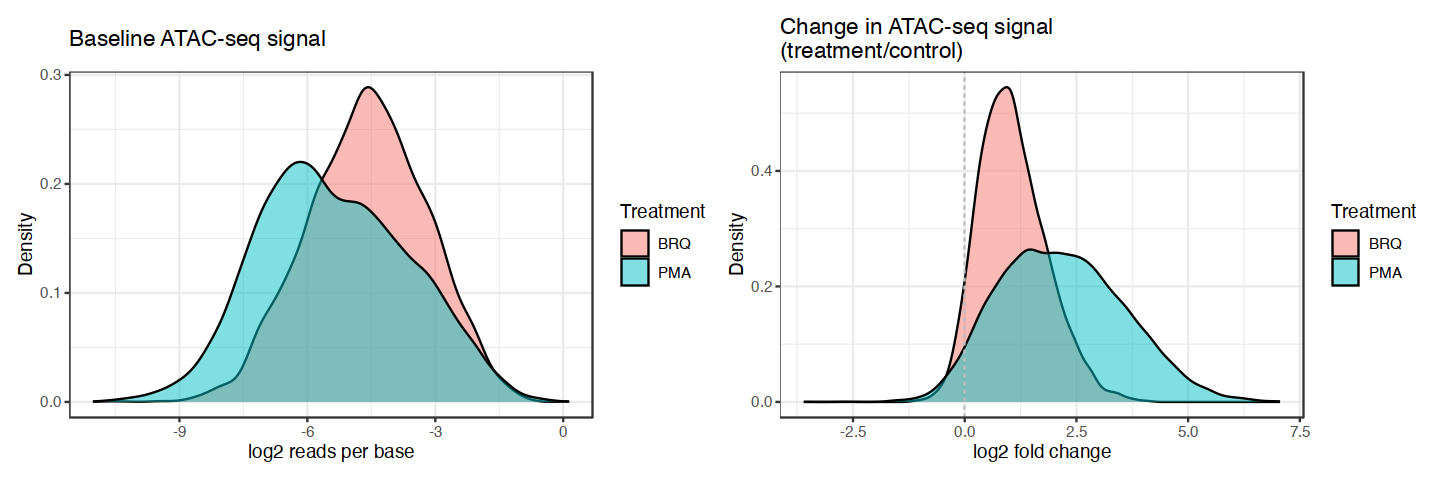

In [43]:
# ATAC ATAC
atac_peak_cts_by_length = apply(df[,1:2], 1, mean)/peak_info$Length  # use kernel 

k27_b24_names = rownames(subset(k27_b24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(k27_b24_dep) %in% enh_peaks))  # 4260
k27_p24_names = rownames(subset(k27_p24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(k27_b24_dep) %in% enh_peaks))  # 13234

df1 = as.data.frame(rbind(cbind(log2(atac_peak_cts_by_length[k27_b24_names]), "BRQ"), 
                         cbind(log2(atac_peak_cts_by_length[k27_p24_names]), "PMA")))
colnames(df1) = c("log2counts", "tx")
df1$log2counts = as.numeric(df1$log2counts)
df1$tx = factor(df1$tx, levels=c("BRQ", "PMA"))

wilcox.test(subset(df1, tx == "BRQ")$log2counts, subset(df1, tx == "PMA")$log2counts)

g1 = ggplot(df1, aes(x=log2counts, fill=tx)) + geom_density(alpha=0.5) + 
scale_fill_manual(values=c("#F8766D", "#00BFC4"), name="Treatment") + theme_bw() +
xlab("log2 reads per base") + ylab("Density") + ggtitle("Baseline ATAC-seq signal")

# H3K27ac change
df2 = as.data.frame(rbind(cbind(b24_dep[k27_b24_names,]$logFC, "BRQ"), 
                         cbind(p24_dep[k27_p24_names,]$logFC, "PMA")))
colnames(df2) = c("log2fc", "tx")
df2$log2fc = as.numeric(df2$log2fc)
df2$tx = factor(df2$tx, levels=c("BRQ", "PMA"))
wilcox.test(subset(df2, tx == "BRQ")$log2fc, subset(df2, tx == "PMA")$log2fc)

g3 = ggplot(df2, aes(x=log2fc, fill=tx)) + geom_density(alpha=0.5) + geom_vline(xintercept=0, linetype=2, color="gray")+
scale_fill_manual(values=c("#F8766D", "#00BFC4"), name="Treatment") + theme_bw() +
xlab("log2 fold change") + ylab("Density") + ggtitle("Change in ATAC-seq signal\n(treatment/control)")
options(repr.plot.width=12, repr.plot.height=4)

g1 + g3

In [44]:
# median ATAC signal of peaks that get activated by each stimulus
median(atac_peak_cts_by_length[k27_b24_names])
median(atac_peak_cts_by_length[k27_p24_names])
median(atac_peak_cts_by_length[setdiff(k27_p24_names,k27_b24_names)])
median(atac_peak_cts_by_length[setdiff(k27_b24_names,k27_p24_names)])
median(atac_peak_cts_by_length[intersect(k27_b24_names,k27_p24_names)])
#median(atac_peak_cts_by_length[random])

[1] 0.04223719

[1] 0.02195122

[1] 0.01956352

[1] 0.04273985

[1] 0.04077352

Warning message:
“Removed 42 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 42 rows containing non-finite values (`stat_density()`).”


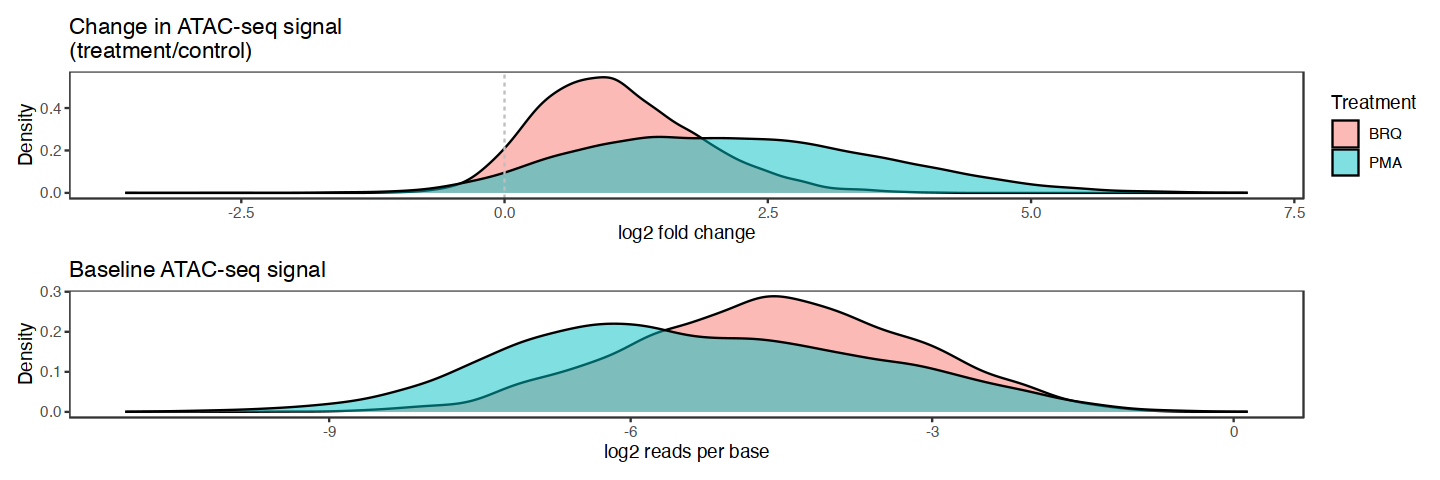

In [45]:
g1 = g1 + theme(panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(),
           legend.position="none")
g3 = g3 + theme(panel.grid.major = element_blank(),
           panel.grid.minor = element_blank())

g3/g1
ggsave("../output/230925_thp1_k27acup_atac_counts.pdf", width=4, height=4)

### Normalize by library size

This is necessary because I only have one replicate for the 48h H3K27ac

In [31]:
df_summ = read.table("../data/220612_thp1_atac_k27ac_pu1_mll_at_atac.txt.summary", header=T, row.names=1)
df_librarysize = apply(df_summ,2,sum)

# normalize by library size, multiply by 1 million
df_norm_lb = sweep(df, 2, df_librarysize, `/`) * 1e6

# normalize by bp of peak size, multiply by 1000
df_norm = sweep(df_norm_lb, 1, peak_info$Length, `/`) * 1e3
head(df_norm)

,dmso_r1,dmso_r2,b24_r1,b24_r2,b48_r1,b48_r2,p24_r1,p24_r2,p48_r1,p48_r2,⋯,b24_pu1,b48_pu1,p24_pu1,p48_pu1,d_mll1,b24_mll1,p24_mll1,d_mll3,b24_mll3,p24_mll3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak1,0.5774096,0.4411291,1.5896134,0.5368706,5.4839398,4.2936656,3.934790,4.444859,11.259148,9.768722,⋯,0.7672000,2.633625,2.9648304,2.7940909,0.3325784,0.2310456,0.7315389,0.5397135,0.4564515,0.4822153
peak2,0.6482574,1.2735138,1.5252600,1.9589191,3.1910326,2.3995831,4.919585,3.274845,10.142870,9.417606,⋯,3.1620061,3.505202,5.8005982,6.5664718,1.9602744,1.0700036,2.8558782,0.5942834,0.5380808,0.4060371
peak3,0.0000000,0.0000000,0.4352879,0.7901930,7.6121803,8.1651871,2.105971,1.635541,2.605170,3.125672,⋯,1.4263620,6.752265,4.3637853,5.0331873,0.0000000,1.7003225,0.9788322,0.6110594,0.6718281,1.0139264
peak4,5.1544369,5.9956504,11.6717495,13.1164595,19.2926028,17.5130751,19.243232,17.130930,22.730488,20.354185,⋯,7.9110601,8.202527,12.0451413,8.5819003,3.5626451,7.1644911,7.1239889,0.5266563,0.9007154,0.7767795
peak5,8.6884798,7.6148154,5.1581069,6.0384570,7.7253296,7.1729198,7.720437,7.347031,9.146945,9.425131,⋯,1.9884955,1.626999,3.1809496,2.5861308,4.6707934,5.5309909,5.2157776,0.6815038,0.5827719,0.1884690
peak6,1.9750646,2.2633632,0.8851531,1.8363986,0.4575158,0.7798271,1.019636,1.662928,3.195368,2.421341,⋯,0.9668305,0.145298,0.7456899,0.8558828,1.5926466,0.3951528,0.4549588,0.2840189,0.1561320,0.4712705


In [32]:
# combine replicates from atacs done at the same time
df_norm_atac_comb = (df_norm[,(seq(1,5) * 2 - 1)] + df_norm[,(seq(1,5) * 2)])/2
colnames(df_norm_atac_comb) = gsub("_r1", "", colnames(df_norm_atac_comb))
df_norm_comb = cbind(df_norm_atac_comb, df_norm[,11:dim(df_norm)[2]])
head(df_norm_comb)

,dmso,b24,b48,p24,p48,d_k27ac,b24_k27ac,b48_k27ac,p24_k27ac,p48_k27ac,⋯,b24_pu1,b48_pu1,p24_pu1,p48_pu1,d_mll1,b24_mll1,p24_mll1,d_mll3,b24_mll3,p24_mll3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak1,0.5092693,1.0632420,4.8888027,4.189825,10.513935,0.6066292,1.0283621,2.8669866,2.091893,8.6886548,⋯,0.7672000,2.633625,2.9648304,2.7940909,0.3325784,0.2310456,0.7315389,0.5397135,0.4564515,0.4822153
peak2,0.9608856,1.7420896,2.7953078,4.097215,9.780238,1.3752218,3.0494954,3.0252308,3.622553,7.3930718,⋯,3.1620061,3.505202,5.8005982,6.5664718,1.9602744,1.0700036,2.8558782,0.5942834,0.5380808,0.4060371
peak3,0.0000000,0.6127404,7.8886837,1.870756,2.865421,0.5494567,1.3161692,2.9912321,2.439924,5.5192023,⋯,1.4263620,6.752265,4.3637853,5.0331873,0.0000000,1.7003225,0.9788322,0.6110594,0.6718281,1.0139264
peak4,5.5750437,12.3941045,18.4028389,18.187081,21.542337,1.8416321,5.6088406,6.7009249,6.063940,13.0201263,⋯,7.9110601,8.202527,12.0451413,8.5819003,3.5626451,7.1644911,7.1239889,0.5266563,0.9007154,0.7767795
peak5,8.1516476,5.5982819,7.4491247,7.533734,9.286038,5.7449942,4.5668010,2.4490979,6.155105,9.8420779,⋯,1.9884955,1.626999,3.1809496,2.5861308,4.6707934,5.5309909,5.2157776,0.6815038,0.5827719,0.1884690
peak6,2.1192139,1.3607759,0.6186715,1.341282,2.808355,1.1173142,0.7646902,0.3724064,1.485092,0.9385286,⋯,0.9668305,0.145298,0.7456899,0.8558828,1.5926466,0.3951528,0.4549588,0.2840189,0.1561320,0.4712705


In [33]:
k27_b24_names = rownames(subset(k27_b24_dep, logFC > 1 & adj.P.Val < 0.05))
k27_p24_names = rownames(subset(k27_p24_dep, logFC > 1 & adj.P.Val < 0.05))
random = rownames(k27_p24_dep[sample(nrow(k27_p24_dep), 10000),])

dfx = as.data.frame(rbind(cbind(log2(df_norm_comb[k27_b24_names,]$dmso), "BRQ"), 
                          cbind(log2(df_norm_comb[k27_p24_names,]$dmso), "PMA"),
                          cbind(log2(df_norm_comb[random,]$dmso), "Random")))
colnames(dfx) = c("log2counts", "tx")
dfx$peaknames = c(k27_b24_names, k27_p24_names, random)
dfx$log2counts = as.numeric(dfx$log2counts)
dfx$tx = factor(dfx$tx, levels=c("Random", "BRQ", "PMA"))
head(dfx)

,log2counts,tx,peaknames
,<dbl>,<fct>,<chr>
1,1.8328769,BRQ,peak150115
2,0.4473678,BRQ,peak149055
3,1.7322307,BRQ,peak125484
4,0.4794274,BRQ,peak138405
5,-0.1184821,BRQ,peak118543
6,1.1850123,BRQ,peak160482


Warning message:
“Removed 69 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 69 rows containing non-finite values (`stat_density()`).”


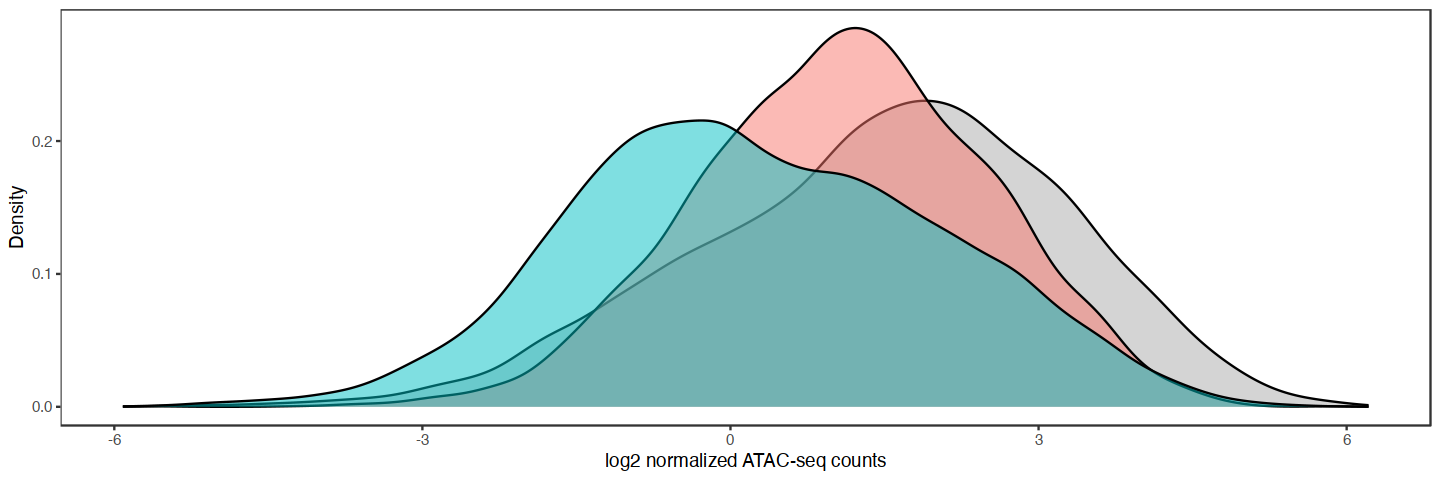

In [34]:
# plot for paper
g1 = ggplot(dfx, aes(x=log2counts, fill=tx)) + geom_density(alpha=0.5) + 
scale_fill_manual(values=c("darkgray", "#F8766D", "#00BFC4"), name="Treatment") + theme_bw() +
xlab("log2 normalized ATAC-seq counts") + ylab("Density")

options(repr.plot.width=12, repr.plot.height=4)
g1 + theme(panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(),
           legend.position="none")
ggsave("../output/230620_thp_k27acup_atac_counts.pdf", width=4, height=3)

Warning message:
“Removed 59 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 10 rows containing non-finite values (`stat_density()`).”


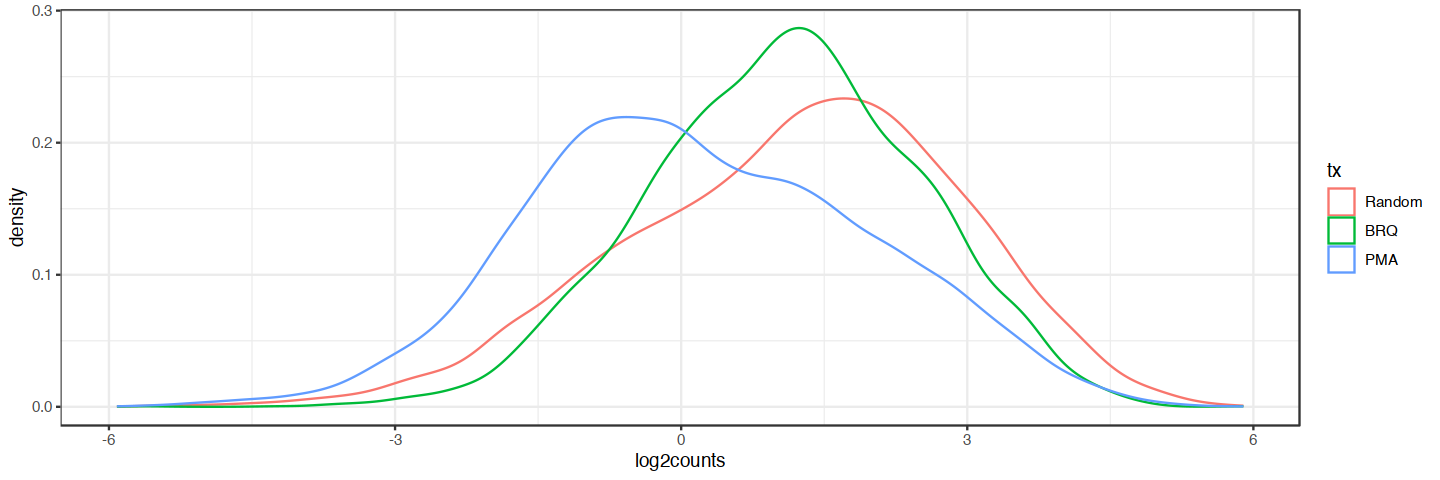

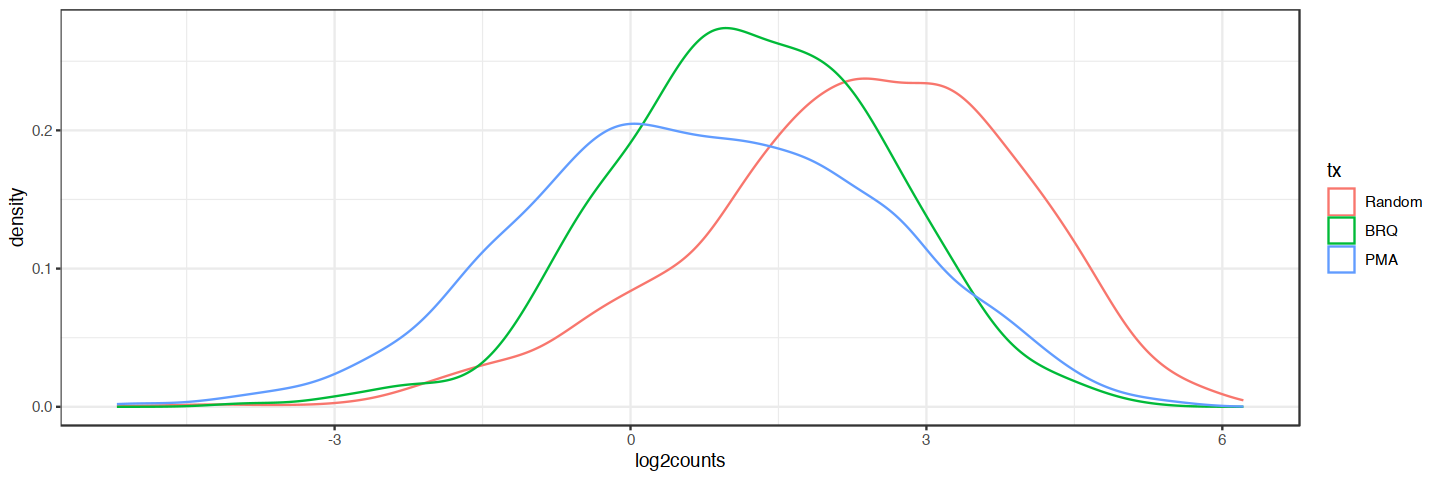

In [35]:
# tss or enh
ggplot(subset(dfx, peaknames %in% enh_peaks), aes(x=log2counts, color=tx)) + geom_density() + theme_bw()
ggplot(subset(dfx, !(peaknames %in% enh_peaks)), aes(x=log2counts, color=tx)) + geom_density() + theme_bw()

## Concordance between peak accessibility and gene expression

In [37]:
# make a list of peaks with >25% ATAC signal at some point during treatment, and >25% K4me1 signal for GREAT
tatac = as.numeric(quantile(df_norm_comb$dmso, 0.25))
tk27ac = as.numeric(quantile(df_norm_comb$d_k27ac, 0.25))

df_norm_comb_hi = subset(df_norm_comb, (apply(df_norm_comb[,1:5], 1, max) > tatac) &
                                       (apply(df_norm_comb[,6:10], 1, max) > tk27ac))
dim(df_norm_comb_hi)

[1] 169811     27

In [38]:
# make bed file for GREAT
df_norm_comb_hi_bed = peak_info[rownames(df_norm_comb_hi),]
df_norm_comb_hi_bed = cbind(df_norm_comb_hi_bed[,1:3], rownames(df_norm_comb_hi_bed), df_norm_comb_hi_bed$Length, df_norm_comb_hi_bed$Strand)
head(df_norm_comb_hi_bed)
#write.table(df_norm_comb_hi_bed, file = "../output/220226_thp1_atac_k27achi.bed", quote = F, col.names=F, row.names=F)

,Chr,Start,End,rownames(df_norm_comb_hi_bed),df_norm_comb_hi_bed$Length,df_norm_comb_hi_bed$Strand
,<chr>,<int>,<int>,<chr>,<int>,<chr>
peak1,chr1,807052,807600,peak1,549,+
peak2,chr1,807670,808321,peak2,652,+
peak3,chr1,810868,811240,peak3,373,+
peak4,chr1,817208,817986,peak4,779,+
peak5,chr1,826704,827907,peak5,1204,+
peak6,chr1,838302,838622,peak6,321,+


In [56]:
# 9/25/23: use enhancer peaks that are not filtered, and do 100kb. this is to apply same processing methods as ER-Hoxa9
enh_peaks_for_great = peak_info[enh_peaks,]
enh_peaks_for_great = cbind(enh_peaks_for_great[,1:3], rownames(enh_peaks_for_great), enh_peaks_for_great$Length, enh_peaks_for_great$Strand)
head(enh_peaks_for_great)
write.table(enh_peaks_for_great, file = "../output/230925_thp1_enh_peaks_for_great.bed", quote = F, col.names=F, row.names=F)

,Chr,Start,End,rownames(enh_peaks_for_great),enh_peaks_for_great$Length,enh_peaks_for_great$Strand
,<chr>,<int>,<int>,<chr>,<int>,<chr>
peak1,chr1,807052,807600,peak1,549,+
peak2,chr1,807670,808321,peak2,652,+
peak3,chr1,810868,811240,peak3,373,+
peak6,chr1,838302,838622,peak6,321,+
peak8,chr1,867523,867956,peak8,434,+
peak11,chr1,890848,891115,peak11,268,+


In [39]:
# processing region-gene associations from GREAT
#great_data = read.table("../data/20220226-public-4.0.4-WIViwg-hg38-all-region.txt", sep='\t')  # 50kb, and filtered; from 220226_thp1_atac_k27achi.bed
great_data = read.table("../data/20230925-public-4.0.4-X5G2nS-hg38-all-region.txt", sep='\t')  # 100kb, not filtered; from 230925_thp1_enh_peaks_for_great.bed

great_data = great_data[great_data$V2 != "NONE",]
great_data$gene = sapply(great_data$V2, function(x) strsplit(x, split = ' ')[[1]][1])
great_data$dist = sapply(great_data$V2, function(x) strsplit(x, split = ' ')[[1]][2])
great_data$dist = as.numeric(gsub('(', '', gsub(')', '', great_data$dist, fixed=T), fixed=T))
rownames(great_data) = great_data$V1
colnames(great_data) = c("peak_id", "great_output", "gene", "dist")
great_data = subset(great_data, abs(dist) < 100000)
head(great_data)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


,peak_id,great_output,gene,dist
,<chr>,<chr>,<chr>,<dbl>
peak6,peak6,SAMD11 (-87276),SAMD11,-87276
peak8,peak8,SAMD11 (-57998),SAMD11,-57998
peak11,peak11,SAMD11 (-34756),SAMD11,-34756
peak12,peak12,SAMD11 (-21736),SAMD11,-21736
peak13,peak13,SAMD11 (-21146),SAMD11,-21146
peak26,peak26,PERM1 (-3303),PERM1,-3303


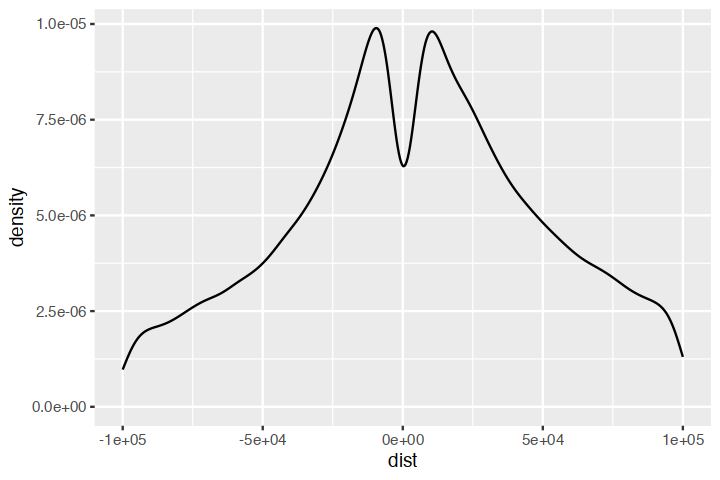

In [40]:
# distance of peaks from TSS
options(repr.plot.height=4, repr.plot.width=6)
ggplot(great_data, aes(x=dist)) + geom_density()

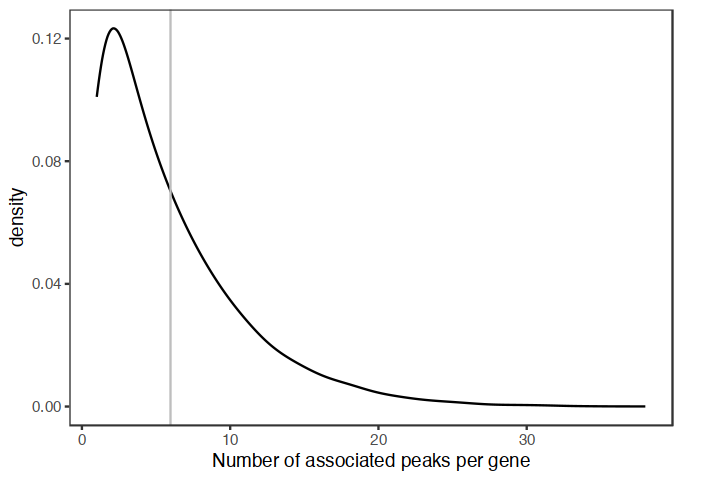

In [41]:
# number of regions per gene
counts = great_data %>% count(gene)
rownames(counts) = counts$gene
ggplot(counts, aes(x=n)) + geom_density(adjust=2) +
geom_vline(xintercept=6, color="gray") + xlab("Number of associated peaks per gene") +
           theme_bw() + theme(panel.grid.major = element_blank(), 
                              panel.grid.minor = element_blank(),
                              plot.margin = unit(c(0.2,1,0.2,0.2), "cm"))
#ggsave("../output/220226_thp1_num_peaks.pdf", width=3, height=2.5) 

In [42]:
# high complexity genes -- top tertile
z = as.numeric(quantile(counts$n, 0.666))
print(z)
z = 3
counts_high = subset(counts, n >= z)
dim(counts_high)

[1] 6


[1] 10165     2

## Gene exp vs promoter H3k27ac

In [43]:
degs = readRDS("../data/230621_bd262_data.rds")
b24_deg = degs[[1]]
b48_deg = degs[[2]]
p24_deg = degs[[3]]
p48_deg = degs[[4]]

In [44]:
# promoter peaks
tss_peaks_df = subset(peakAnno, annobrief == "Promoter")
head(tss_peaks_df)

,seqnames,start,end,width,strand,peak_id,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME,annobrief
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
4,chr1,817208,817986,779,*,peak4,Promoter (<=1kb),1,817371,819837,2467,1,400728,ENST00000326734.2,0,ENSG00000177757,FAM87B,family with sequence similarity 87 member B,Promoter
5,chr1,826704,827907,1204,*,peak5,Promoter (<=1kb),1,594308,827769,233462,2,105378947,ENST00000635509.2,0,NA,LOC105378947,proline-rich extensin-like protein EPR1,Promoter
7,chr1,851392,852052,661,*,peak7,Promoter (<=1kb),1,851348,852752,1405,1,643837,ENST00000425657.1,44,ENSG00000228794,LINC01128,long intergenic non-protein coding RNA 1128,Promoter
9,chr1,869669,870062,394,*,peak9,Promoter (<=1kb),1,868240,870201,1962,2,284593,ENST00000432963.1,139,ENSG00000230368,FAM41C,family with sequence similarity 41 member C,Promoter
10,chr1,876383,877318,936,*,peak10,Promoter (<=1kb),1,868071,876903,8833,2,284593,ENST00000446136.1,0,ENSG00000230368,FAM41C,family with sequence similarity 41 member C,Promoter
14,chr1,911189,911508,320,*,peak14,Promoter (<=1kb),1,911435,914948,3514,1,284600,ENST00000448179.1,0,NA,LOC284600,uncharacterized LOC284600,Promoter



	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 22.532, df = 3307, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3348958 0.3939842
sample estimates:
      cor 
0.3648073 



	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 12.893, df = 1230, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2948896 0.3933260
sample estimates:
      cor 
0.3450563 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


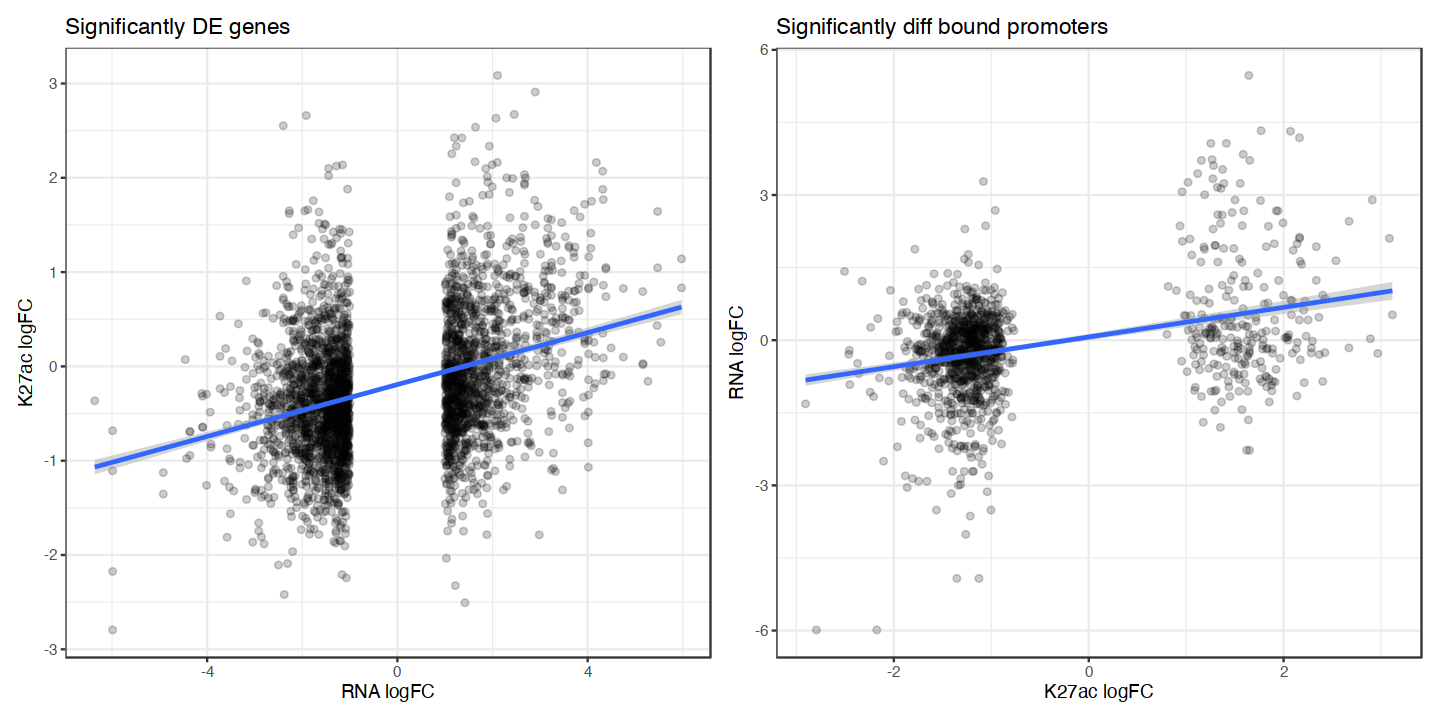

In [45]:
# B24
k27_b24_dep_tss = merge(k27_b24_dep[tss_peaks,], tss_peaks_df[,c("peak_id", "SYMBOL")], by.x=0, by.y="peak_id")
k27_b24_dep_tss = merge(k27_b24_dep_tss, b24_deg, by.x="SYMBOL", by.y=0)

k27_b24_dep_tss_rnasig = subset(k27_b24_dep_tss, abs(logFC.y) > 1 & adj.P.Val.y < 0.05)
g1 = ggplot(k27_b24_dep_tss_rnasig, aes(x=logFC.y, y=logFC.x)) + geom_point(alpha=0.2) + 
geom_smooth(method="lm") + theme_bw() + xlab("RNA logFC") + ylab("K27ac logFC") + ggtitle("Significantly DE genes")

k27_b24_dep_tss_k27sig = subset(k27_b24_dep_tss, abs(logFC.x) > 0.5 & adj.P.Val.x < 0.05)
g2 = ggplot(k27_b24_dep_tss_k27sig, aes(x=logFC.x, y=logFC.y)) + geom_point(alpha=0.2) + 
geom_smooth(method="lm") + theme_bw() + xlab("K27ac logFC") + ylab("RNA logFC") + ggtitle("Significantly diff bound promoters")

with(k27_b24_dep_tss_rnasig, cor.test(logFC.y, logFC.x))
with(k27_b24_dep_tss_k27sig, cor.test(logFC.y, logFC.x))

options(repr.plot.width=12, repr.plot.height=6)
g1 + g2


	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 62.426, df = 6271, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6035803 0.6341126
sample estimates:
      cor 
0.6190804 



	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 55.286, df = 5125, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.593781 0.628085
sample estimates:
    cor 
0.61122 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


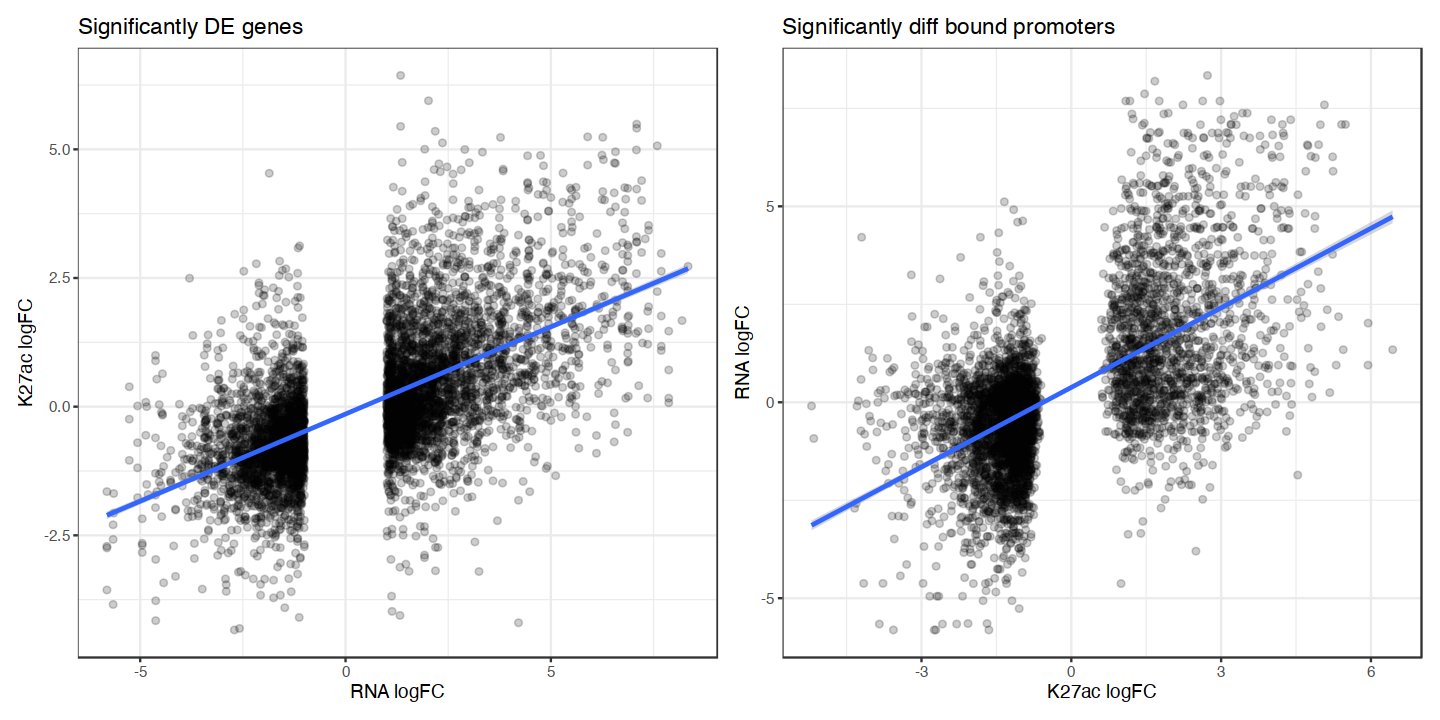

In [46]:
# p24
k27_p24_dep_tss = merge(k27_p24_dep[tss_peaks,], tss_peaks_df[,c("peak_id", "SYMBOL")], by.x=0, by.y="peak_id")
k27_p24_dep_tss = merge(k27_p24_dep_tss, p24_deg, by.x="SYMBOL", by.y=0)

k27_p24_dep_tss_rnasig = subset(k27_p24_dep_tss, abs(logFC.y) > 1 & adj.P.Val.y < 0.05)
g1 = ggplot(k27_p24_dep_tss_rnasig, aes(x=logFC.y, y=logFC.x)) + geom_point(alpha=0.2) + 
geom_smooth(method="lm") + theme_bw() + xlab("RNA logFC") + ylab("K27ac logFC") + ggtitle("Significantly DE genes")

k27_p24_dep_tss_k27sig = subset(k27_p24_dep_tss, abs(logFC.x) > 0.5 & adj.P.Val.x < 0.05)
g2 = ggplot(k27_p24_dep_tss_k27sig, aes(x=logFC.x, y=logFC.y)) + geom_point(alpha=0.2) + 
geom_smooth(method="lm") + theme_bw() + xlab("K27ac logFC") + ylab("RNA logFC") + ggtitle("Significantly diff bound promoters")

with(k27_p24_dep_tss_rnasig, cor.test(logFC.y, logFC.x))
with(k27_p24_dep_tss_k27sig, cor.test(logFC.y, logFC.x))

options(repr.plot.width=12, repr.plot.height=6)
g1 + g2

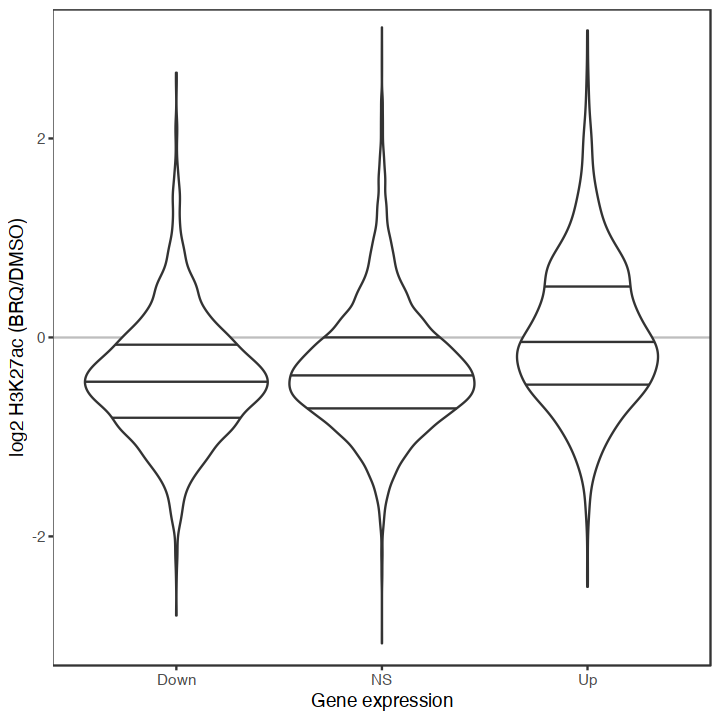

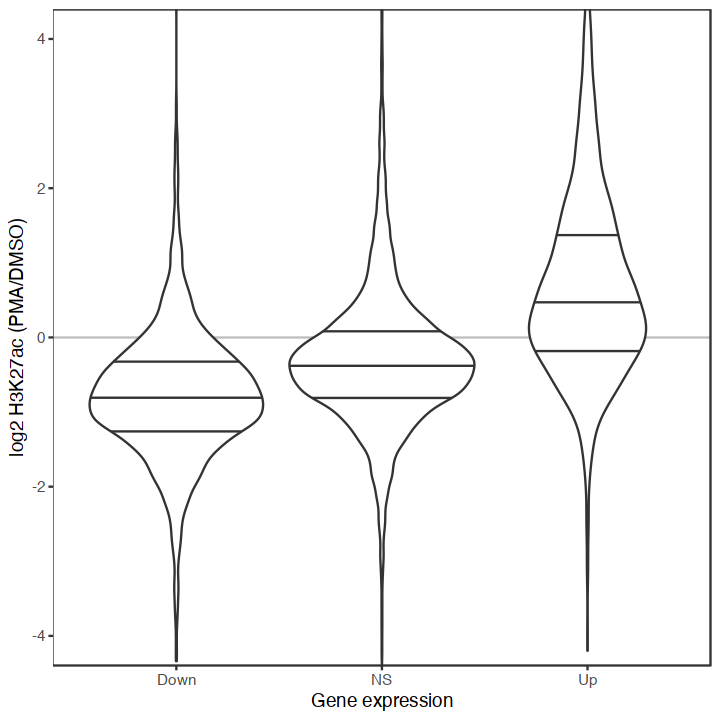

In [47]:
k27_b24_dep_tss$gene_exp = "NS"
k27_b24_dep_tss[(k27_b24_dep_tss$logFC.y > 1 & k27_b24_dep_tss$adj.P.Val.y < 0.05),]$gene_exp = "Up"
k27_b24_dep_tss[(k27_b24_dep_tss$logFC.y < -1 & k27_b24_dep_tss$adj.P.Val.y < 0.05),]$gene_exp = "Down"

k27_p24_dep_tss$gene_exp = "NS"
k27_p24_dep_tss[(k27_p24_dep_tss$logFC.y > 1 & k27_p24_dep_tss$adj.P.Val.y < 0.05),]$gene_exp = "Up"
k27_p24_dep_tss[(k27_p24_dep_tss$logFC.y < -1 & k27_p24_dep_tss$adj.P.Val.y < 0.05),]$gene_exp = "Down"

options(repr.plot.width=6, repr.plot.height=6)
g1 = ggplot(k27_b24_dep_tss, aes(x=gene_exp, y=logFC.x)) + 
geom_hline(yintercept=0, color="gray")+
geom_violin(draw_quantiles = c(.25,.5,.75)) +
#geom_boxplot() +
coord_cartesian(ylim=c(-3,3)) + theme_bw() +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank()) +
xlab("Gene expression") + ylab("log2 H3K27ac (BRQ/DMSO)") 

g2 = ggplot(k27_p24_dep_tss, aes(x=gene_exp, y=logFC.x)) + 
geom_hline(yintercept=0, color="gray")+
geom_violin(draw_quantiles = c(.25,.5,.75)) +
coord_cartesian(ylim=c(-4,4)) + theme_bw() +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank()) +
xlab("Gene expression") + ylab("log2 H3K27ac (PMA/DMSO)") 

g1
ggsave("../output/230920_bd302_thp1_brq_k27ac_prom.pdf", width=2, height=2.5)

g2
ggsave("../output/230920_bd302_thp1_pma_k27ac_prom.pdf", width=2, height=2.5)

In [48]:
# Mann-Whitney tests (promoters)
wilcox.test(subset(k27_b24_dep_tss, gene_exp == "NS")$logFC.y, subset(k27_b24_dep_tss, gene_exp == "Up")$logFC.y)
wilcox.test(subset(k27_b24_dep_tss, gene_exp == "NS")$logFC.y, subset(k27_b24_dep_tss, gene_exp == "Down")$logFC.y)
wilcox.test(subset(k27_p24_dep_tss, gene_exp == "NS")$logFC.y, subset(k27_p24_dep_tss, gene_exp == "Up")$logFC.y)
wilcox.test(subset(k27_p24_dep_tss, gene_exp == "NS")$logFC.y, subset(k27_p24_dep_tss, gene_exp == "Down")$logFC.y)


	Wilcoxon rank sum test with continuity correction

data:  subset(k27_b24_dep_tss, gene_exp == "NS")$logFC.y and subset(k27_b24_dep_tss, gene_exp == "Up")$logFC.y
W = 94686, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(k27_b24_dep_tss, gene_exp == "NS")$logFC.y and subset(k27_b24_dep_tss, gene_exp == "Down")$logFC.y
W = 25676724, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(k27_p24_dep_tss, gene_exp == "NS")$logFC.y and subset(k27_p24_dep_tss, gene_exp == "Up")$logFC.y
W = 62821, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(k27_p24_dep_tss, gene_exp == "NS")$logFC.y and subset(k27_p24_dep_tss, gene_exp == "Down")$logFC.y
W = 28909237, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [36]:
# get GREAT annotations
# this is code that is copied from elsewhere, just repeated here for clarity.

#great_data = read.table("../data/20220226-public-4.0.4-WIViwg-hg38-all-region.txt", sep='\t')  # 50kb, and filtered; from 220226_thp1_atac_k27achi.bed
great_data = read.table("../data/20230925-public-4.0.4-X5G2nS-hg38-all-region.txt", sep='\t')  # 100kb, not filtered; from 230925_thp1_enh_peaks_for_great.bed

great_data = great_data[great_data$V2 != "NONE",]
great_data$gene = sapply(great_data$V2, function(x) strsplit(x, split = ' ')[[1]][1])
great_data$dist = sapply(great_data$V2, function(x) strsplit(x, split = ' ')[[1]][2])
great_data$dist = as.numeric(gsub('(', '', gsub(')', '', great_data$dist, fixed=T), fixed=T))
rownames(great_data) = great_data$V1
colnames(great_data) = c("peak_id", "great_output", "gene", "dist")
great_data = subset(great_data, abs(dist) < 100000)
head(great_data)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


,peak_id,great_output,gene,dist
,<chr>,<chr>,<chr>,<dbl>
peak6,peak6,SAMD11 (-87276),SAMD11,-87276
peak8,peak8,SAMD11 (-57998),SAMD11,-57998
peak11,peak11,SAMD11 (-34756),SAMD11,-34756
peak12,peak12,SAMD11 (-21736),SAMD11,-21736
peak13,peak13,SAMD11 (-21146),SAMD11,-21146
peak26,peak26,PERM1 (-3303),PERM1,-3303


In [49]:
# enhancers

k27_b24_enh = merge(subset(k27_b24_dep, rownames(k27_b24_dep) %in% enh_peaks), great_data, by.x=0, by.y=0)
rownames(k27_b24_enh) = k27_b24_enh$Row.names
k27_b24_enh = merge(k27_b24_enh, b24_deg, by.x="gene", by.y=0)

k27_p24_enh = merge(subset(k27_p24_dep, rownames(k27_p24_dep) %in% enh_peaks), great_data, by.x=0, by.y=0)
rownames(k27_p24_enh) = k27_p24_enh$Row.names
k27_p24_enh = merge(k27_p24_enh, p24_deg, by.x="gene", by.y=0)


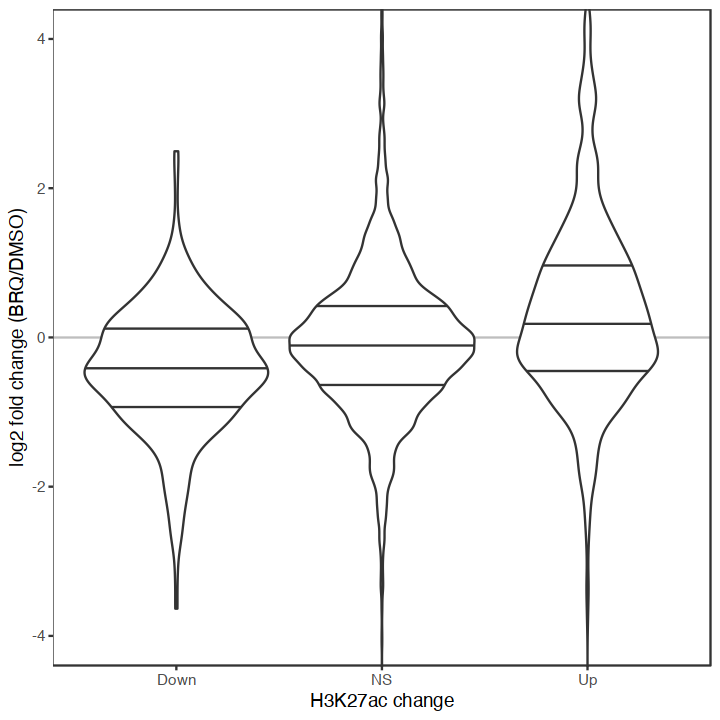

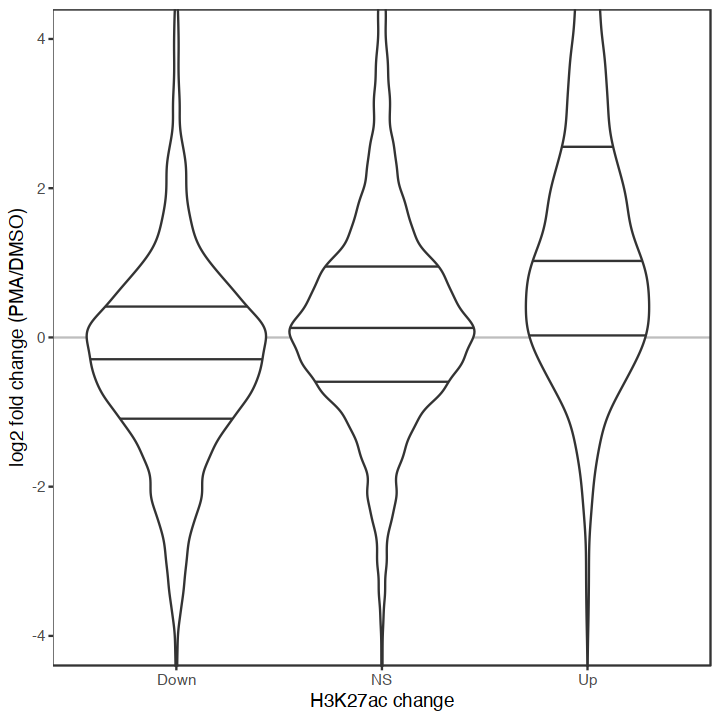

In [50]:
k27_b24_enh$k27_status = "NS"
k27_b24_enh[(k27_b24_enh$logFC.x > 1 & k27_b24_enh$adj.P.Val.x < 0.05),]$k27_status = "Up"
k27_b24_enh[(k27_b24_enh$logFC.x < -1 & k27_b24_enh$adj.P.Val.x < 0.05),]$k27_status = "Down"

k27_p24_enh$k27_status = "NS"
k27_p24_enh[(k27_p24_enh$logFC.x > 1 & k27_p24_enh$adj.P.Val.x < 0.05),]$k27_status = "Up"
k27_p24_enh[(k27_p24_enh$logFC.x < -1 & k27_p24_enh$adj.P.Val.x < 0.05),]$k27_status = "Down"

options(repr.plot.width=6, repr.plot.height=6)
g1 = ggplot(k27_b24_enh, aes(x=k27_status, y=logFC.y)) + 
geom_hline(yintercept=0, color="gray")+
geom_violin(draw_quantiles = c(.25,.5,.75)) +
coord_cartesian(ylim=c(-4,4)) + theme_bw() +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank()) +
xlab("H3K27ac change") + ylab("log2 fold change (BRQ/DMSO)") 

g2 = ggplot(k27_p24_enh, aes(x=k27_status, y=logFC.y)) + 
geom_hline(yintercept=0, color="gray")+
geom_violin(draw_quantiles = c(.25,.5,.75)) +
coord_cartesian(ylim=c(-4,4)) + theme_bw() +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank()) +
xlab("H3K27ac change") + ylab("log2 fold change (PMA/DMSO)") 

g1
ggsave("../output/230920_bd302_thp1_brq_k27ac_enh_rna.pdf", width=2, height=2.5)

g2
ggsave("../output/230920_bd302_thp1_pma_k27ac_enh_rna.pdf", width=2, height=2.5)

In [51]:
# Mann-Whitney tests (enhancers)
wilcox.test(subset(k27_b24_enh, k27_status == "NS")$logFC.x, subset(k27_b24_enh, k27_status == "Up")$logFC.x)
wilcox.test(subset(k27_b24_enh, k27_status == "NS")$logFC.x, subset(k27_b24_enh, k27_status == "Down")$logFC.x)
wilcox.test(subset(k27_p24_enh, k27_status == "NS")$logFC.x, subset(k27_p24_enh, k27_status == "Up")$logFC.x)
wilcox.test(subset(k27_p24_enh, k27_status == "NS")$logFC.x, subset(k27_p24_enh, k27_status == "Down")$logFC.x)


	Wilcoxon rank sum test with continuity correction

data:  subset(k27_b24_enh, k27_status == "NS")$logFC.x and subset(k27_b24_enh, k27_status == "Up")$logFC.x
W = 1289771, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(k27_b24_enh, k27_status == "NS")$logFC.x and subset(k27_b24_enh, k27_status == "Down")$logFC.x
W = 9578974, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(k27_p24_enh, k27_status == "NS")$logFC.x and subset(k27_p24_enh, k27_status == "Up")$logFC.x
W = 3177672, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(k27_p24_enh, k27_status == "NS")$logFC.x and subset(k27_p24_enh, k27_status == "Down")$logFC.x
W = 107583433, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


### Associated peaks

[1] 84427

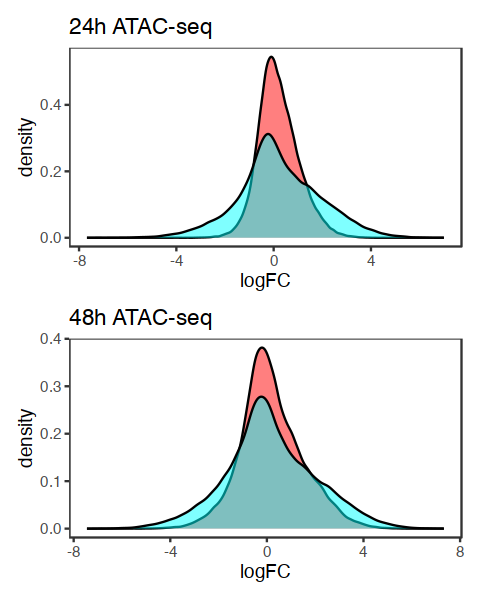

In [52]:
# z is the set of enh peaks within 100kb of genes
# previously we did 50kb and filtered for ATAC and K27ac > 25th percentile... not doing it now.

z = intersect(rownames(b24_dep), rownames(great_data))
length(z)

g1 = ggplot() + geom_density(data = b24_dep[z,], aes(x=logFC), fill="red", alpha=0.5) +
           geom_density(data = p24_dep[z,], aes(x=logFC), fill="cyan", alpha=0.5) + ggtitle("24h ATAC-seq") +
           theme_bw() + theme(panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank())

g2 = ggplot() + geom_density(data = b48_dep[z,], aes(x=logFC), fill="red", alpha=0.5) +
           geom_density(data = p48_dep[z,], aes(x=logFC), fill="cyan", alpha=0.5) + ggtitle("48h ATAC-seq") +
           theme_bw() + theme(panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank())

options(repr.plot.width=4, repr.plot.height=5)
g1 / g2
#ggsave("../output/220226_thp1_peaks_density.pdf", width=4, height=5)

In [53]:
shared_up = intersect(rownames(subset(b24_deg, logFC > 1 & adj.P.Val < 0.05)),
                      rownames(subset(p24_deg, logFC > 1 & adj.P.Val < 0.05)))
shared_up = intersect(shared_up, rownames(counts_high))  # 236 genes

ATAC_LFC_THRESH = 0
length(shared_up)
#head(shared_up)

# peaks that are in both the GREAT data and the differential analysis
z = intersect(rownames(b24_dep), rownames(great_data))

# fraction of peaks that become more accessible in B48
b24_dep_great = cbind(b24_dep[z, ], great_data[z, ])
b24_great_upreg = b24_dep_great[which(b24_dep_great$gene %in% shared_up), ]
b24_frac_up = b24_great_upreg %>% group_by(gene) %>% 
        summarize(Frac = sum((logFC > ATAC_LFC_THRESH) & (adj.P.Val < 0.05))/
                        sum((adj.P.Val <= 1)))
b24_frac_up$lfc = b24_deg[shared_up,]$logFC

# fraction of peaks that become more accessible in P48
p24_dep_great = cbind(p24_dep[z, ], great_data[z, ])
p24_great_upreg = p24_dep_great[which(b24_dep_great$gene %in% shared_up), ]
p24_frac_up = p24_great_upreg %>% group_by(gene) %>% 
        summarize(Frac = sum((logFC > ATAC_LFC_THRESH) & (adj.P.Val < 0.05))/
                        sum((adj.P.Val <= 1)))
p24_frac_up$lfc = p24_deg[shared_up,]$logFC

# merging data frame
frac_24h = merge(b24_frac_up, p24_frac_up, by="gene")
rownames(frac_24h) = frac_24h$gene
colnames(frac_24h) = c("gene", "b24_frac", "b24_lfc", "p24_frac", "p24_lfc")

[1] 236


	Wilcoxon rank sum test with continuity correction

data:  b24_frac and p24_frac
W = 12145, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


[1] 0.1666667

[1] 0.4


	Wilcoxon rank sum test with continuity correction

data:  b24_lfc and p24_lfc
W = 18147, p-value = 5.871e-11
alternative hypothesis: true location shift is not equal to 0


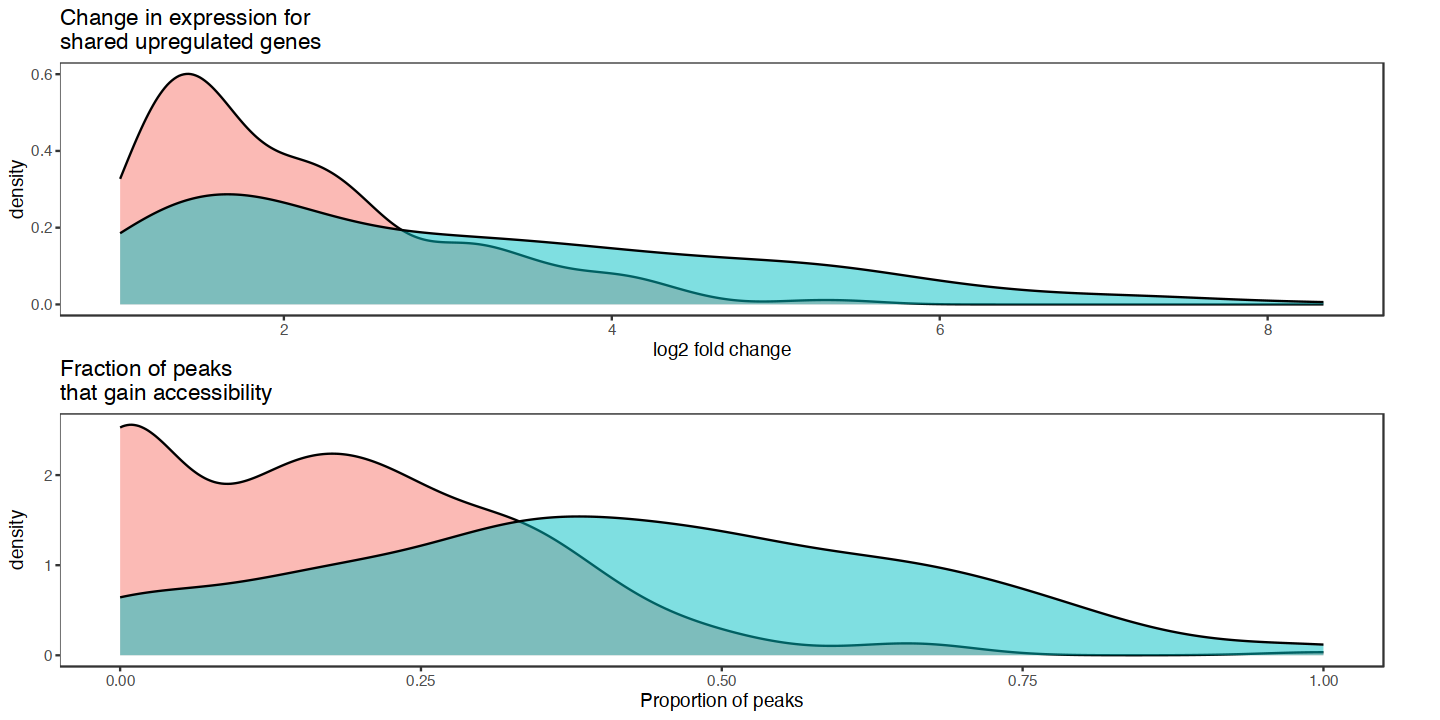

In [54]:
# plotting densities
g1 = ggplot() + geom_density(data=frac_24h, aes(x=b24_frac), fill="#F8766D", alpha=0.5) +
           geom_density(data=frac_24h, aes(x=p24_frac), fill="#00BFC4", alpha=0.5) +
           ggtitle("Fraction of peaks\nthat gain accessibility") + xlab("Proportion of peaks") +
           theme_bw() + theme(panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              plot.margin = unit(c(0,1,0,0), "cm"))

g2 = ggplot() + geom_density(data=frac_24h, aes(x=b24_lfc), fill="#F8766D", alpha=0.5) +
           geom_density(data=frac_24h, aes(x=p24_lfc), fill="#00BFC4", alpha=0.5) +
           ggtitle("Change in expression for\nshared upregulated genes") + xlab("log2 fold change") +
           theme_bw() + theme(panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              plot.margin = unit(c(0,1,0,0), "cm"))

options(repr.plot.width=12, repr.plot.height=6)
g2 / g1
ggsave("../output/230620_thp1_shared_up_genes.pdf", width=4, height=5)

# wilcox test 
with(frac_24h, wilcox.test(b24_frac, p24_frac))
median(frac_24h$b24_frac)
median(frac_24h$p24_frac)
with(frac_24h, wilcox.test(b24_lfc, p24_lfc))

Warning message:
“ggrepel: 120 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 219 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


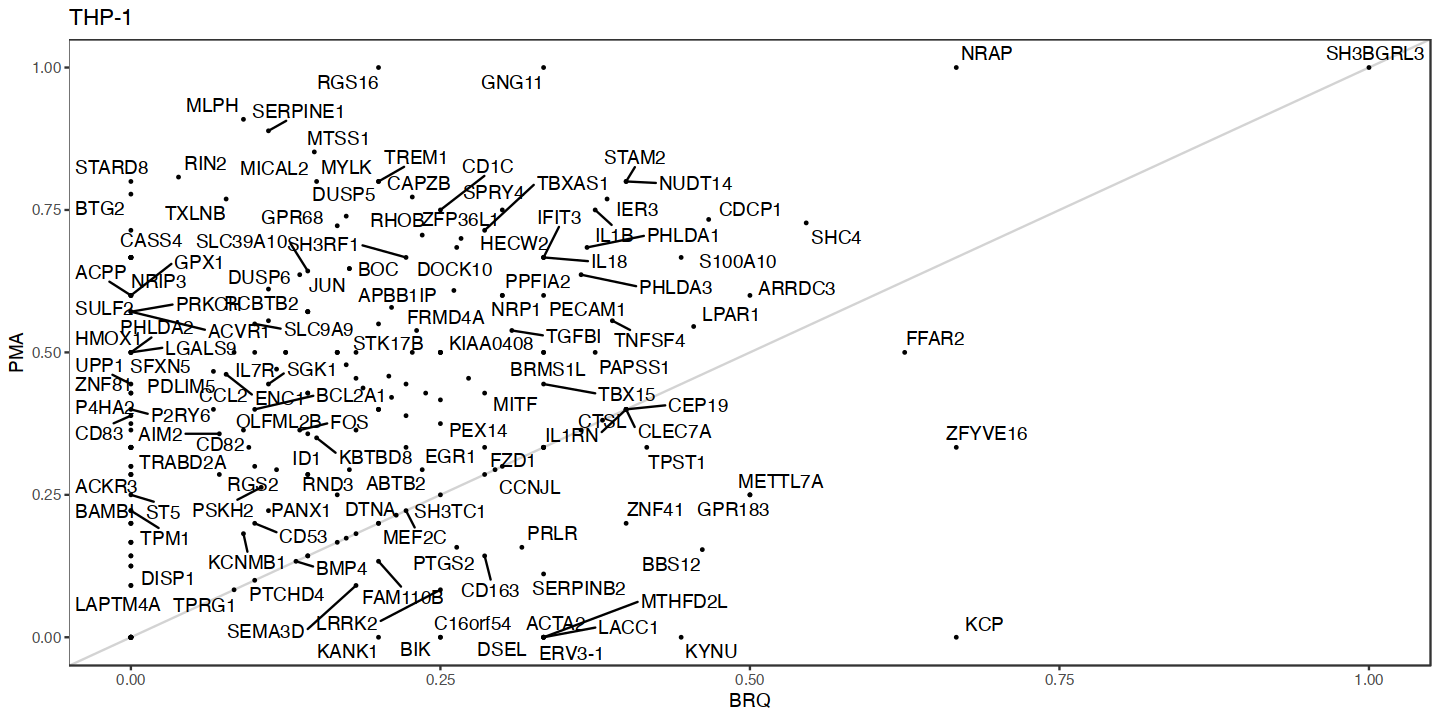

In [57]:
# Plot genes by their LFC vs proportion of accessible peaks
frac_24h$labels = ""
interesting_genes = c("MMP14", "MEF2C", "MERTK", "ZFP36L1", "AIM2", "CD300LB", "CD14", "C5AR1", "FABP4", "FCGR3A", "CSF1R", "HMOX1")
frac_24h[which(rownames(frac_24h) %in% interesting_genes), ]$labels = rownames(frac_24h[which(rownames(frac_24h) %in% interesting_genes), ])

g1 = ggplot(frac_24h, aes(x=b24_lfc, y=p24_lfc, label=gene)) + geom_point() +
           theme_bw() + theme(panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank()) +
            geom_text_repel(max.overlaps=10)
g2 = ggplot(frac_24h, aes(x=b24_frac, y=p24_frac, label=gene)) + 
            geom_abline(slope=1, intercept=0, color="lightgray") + geom_point(size=0.3) +
           theme_bw() + theme(panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank()) +
            geom_text_repel(max.overlaps=10) + xlab("BRQ") + ylab("PMA") + 
            ggtitle("THP-1")
    

options(repr.plot.width=12, repr.plot.height=6)
g2
ggsave("../output/230925_thp_shared_up_genes_scatter.pdf", width=4, height=4)


In [58]:
with(frac_24h, sum(b24_frac > p24_frac, na.rm=T))
with(frac_24h, sum(b24_frac == p24_frac, na.rm=T))
with(frac_24h, sum(b24_frac < p24_frac, na.rm=T))

[1] 24

[1] 40

[1] 172